In [1]:
import sys
import importlib
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')

from __init__ import *
import __init__jupyterlab
importlib.reload(__init__jupyterlab)
from __init__jupyterlab import *
from matplotlib.ticker import MaxNLocator

import collections
import itertools
import tables
from adjustText import adjust_text

from scipy import sparse
from scipy import stats
from scipy import optimize 
import scipy.cluster.hierarchy as sch
import fbpca
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_clst_utils
importlib.reload(CEMBA_clst_utils)



<module 'CEMBA_clst_utils' from '/cndd/fangming/CEMBA/snmcseq_dev/CEMBA_clst_utils.py'>

### Enhancer-gene project pilot notebook


- mCG (not normalized, cluster level)
- RNA logTPM (normalized, cell level mean) 
- mCH normalized by global mean (normalized, cluster level)
- ATAC CPM (normalized, cluster level)


## Basic settings 

- gene annotation
- metadata
- gene features
- clustering and annotation

In [2]:
output_figures = '/cndd2/fangming/scf_enhancers/results/figures/{}_191130.{}'

In [5]:
f = '/cndd/Public_Datasets/CEMBA/snmCSeq/References/Annotation/gencode.vM16.annotation_genes.tsv'
df_genes = pd.read_csv(f, sep='\t')
df_genes_v2 = df_genes.groupby('gene_name').first()
df_genes_v2['chrom'] = df_genes_v2['chr'].apply(lambda x: (x[3:]))
df_genes_v2.head()

,gene_id,chr,start,end,strand,gene_type,chrom
gene_name,,,,,,,
0610005C13Rik,ENSMUSG00000109644.1,chr7,45567794,45575327,-,antisense_RNA,7
0610006L08Rik,ENSMUSG00000108652.1,chr7,74818818,74853813,-,lincRNA,7
0610009B22Rik,ENSMUSG00000007777.9,chr11,51685386,51688874,-,protein_coding,11
0610009E02Rik,ENSMUSG00000086714.1,chr2,26445696,26459390,+,processed_transcript,2
0610009L18Rik,ENSMUSG00000043644.4,chr11,120348678,120351190,+,bidirectional_promoter_lncRNA,11


### Get joint clustering 

In [11]:
# get cluster annotation
clst_annot = {
    1 : 'L2/3',
  2 : 'L4',
  3 : 'L5IT',
  4 : 'L2/3',
  5 : 'L6CT',
  6 : 'L6IT',
  7 : 'L6CT',
  8 : 'L6IT',
  9 : 'L5IT',
  10 : 'L6CT',
  11 : 'L6CT',
  12 : 'L4',
  13 : 'Pv',
  14 : 'L2/3',
  15 : 'L6IT',
  16 : 'L5PT',
  17 : 'Ndnf',
  18 : 'nan',
  19 : 'Vip',
  20 : 'Sst',
  21 : 'L5/6NP',
  22 : 'L5IT',
  23 : 'L5IT',
  24 : 'L5PT',
  25 : 'Pv',
  26 : 'L6CT',
  27 : 'Sst',
  28 : 'Ndnf',
  29 : 'L4',
  30 : 'L2/3',
  31 : 'Vip',
  32 : 'L2/3',
  33 : 'L6CT',
  34 : 'Ndnf',
  35 : 'nan',
  36 : 'Sst',
  37 : 'L6CT',
  38 : 'L5/6NP',
  39 : 'Pv',
  40 : 'Sst',
  41 : 'nan',
  42 : 'Pv',
  43 : 'nan',
  44 : 'Sst',
  45 : 'L6CT',
  46 : 'nan',
  47 : 'Clstr',
  48 : 'L2/3',
  49 : 'Sst',
  50 : 'nan',
  51 : 'Pv',
  52 : 'nan',
  53 : 'nan',
  54 : 'nan',
}

In [12]:
pd.Series(clst_annot).to_frame().reset_index().sort_values([0, 'index'])

,index,0
46,47,Clstr
0,1,L2/3
3,4,L2/3
13,14,L2/3
29,30,L2/3
31,32,L2/3
47,48,L2/3
1,2,L4
11,12,L4
28,29,L4


In [13]:
# get integrated clustering
f = '/cndd/Public_Datasets/CEMBA/snmCSeq/Ensembles/Ens100/cell_info.tsv'
intg_clst = pd.read_csv(f, sep='\t')
print(len(intg_clst['cluster_ID'].unique()))
intg_clst['cluster'] = intg_clst['cluster_ID'].apply(lambda x: int(x[len('cluster_'):]))

# include annotation
intg_clst['annotation'] = intg_clst['cluster'].apply(lambda x: clst_annot[x])
intg_clst.head()

54


,sample,cluster_ID,tsne_x,tsne_y,modality,cluster,annotation
0,SM-GE653_S113_E1-50,cluster_28,25.665414,-24.553544,snrna,28,Ndnf
1,SM-GE653_S114_E1-50,cluster_28,23.874565,-21.141237,snrna,28,Ndnf
2,SM-GE653_S115_E1-50,cluster_34,20.783336,-6.606048,snrna,34,Ndnf
3,SM-GE653_S117_E1-50,cluster_28,24.488323,-24.852014,snrna,28,Ndnf
4,SM-GE653_S118_E1-50,cluster_31,2.924461,-19.134132,snrna,31,Vip


### get cluster level gene features 

In [14]:
# get rna expression for each cluster

_x = gxc_ftrs['smarter_nuclei']
gene_rna = pd.DataFrame(_x.data.todense(), index=_x.gene, columns=_x.cell)
print(gene_rna.shape)

gene_rna_clsts = pd.DataFrame(index=gene_rna.index)
for clst, df_sub in intg_clst[intg_clst['modality']=='snrna'].groupby('cluster'):
    cells = df_sub['sample'].values 
    cells = np.intersect1d(cells, gene_rna.columns.values)
    gene_rna_clsts[clst] = gene_rna[cells].mean(axis=1)
    
# remove duplicated rows
gene_rna_clsts = gene_rna_clsts.loc[~gene_rna_clsts.index.duplicated()]
# remove Nan
gene_rna_clsts = gene_rna_clsts.dropna(axis=1)

print(gene_rna_clsts.shape) #gene and sample
gene_rna_clsts.head()

(14138, 5911)
(14104, 46)


,1,2,3,4,5,6,7,8,9,10,...,39,40,42,44,45,46,48,49,51,52
0610007P14Rik,0.568340,0.652266,0.616715,0.412478,0.560137,0.642278,0.645203,0.781572,0.670875,0.614519,...,0.554905,0.505767,0.604607,0.773979,0.613744,0.434611,1.344004,0.569161,0.554021,0.406559
0610009B22Rik,0.566531,0.681330,0.745966,0.616308,0.632524,0.900620,0.594629,0.921161,0.819379,0.754323,...,0.903613,1.081451,0.650132,0.737585,0.841935,0.991078,3.063325,0.780183,0.934057,0.763668
0610009L18Rik,0.142346,0.063171,0.172858,0.108720,0.117657,0.081912,0.112947,0.106434,0.172557,0.085307,...,0.350009,0.297109,0.288406,0.175884,0.372984,0.106458,0.000000,0.104202,0.000000,0.048244
0610009O20Rik,0.354621,0.392185,0.320798,0.391331,0.287608,0.353210,0.301200,0.320780,0.297949,0.253797,...,0.515054,0.440415,0.320499,0.325044,0.200965,0.336015,0.000000,0.385266,0.437654,0.355165
0610010F05Rik,1.172898,1.019044,1.309579,1.195189,1.094047,1.327212,1.080653,1.075683,1.395863,1.087894,...,0.900609,0.887509,0.879890,0.662089,1.165126,1.100029,2.049055,0.895397,1.006324,0.933520


In [15]:
# # get mCH for each cluster

# gene_mch = gxc_ftrs['snmcseq_gene']
# print(gene_mch.shape)

# gene_mch_clsts = pd.DataFrame(index=gene_mch.index)
# for clst, df_sub in intg_clst[intg_clst['modality']=='mc'].groupby('cluster'):
#     cells = df_sub['sample'].values 
#     cells = np.intersect1d(cells, gene_mch.columns.values)
#     gene_mch_clsts[clst] = gene_mch[cells].mean(axis=1)
    
# # remove duplicated rows
# gene_mch_clsts = gene_mch_clsts.loc[~gene_mch_clsts.index.duplicated()]
# # remove Nan
# gene_mch_clsts = gene_mch_clsts.dropna(axis=1)

# print(gene_mch_clsts.shape) #gene and sample
# gene_mch_clsts.head()

In [16]:
# get mCH for each cluster (alternative way)

mod = 'snmcseq_gene'
_x = gxc_raws[mod]
_xtmp_data_c = _x.data['c'].tocsc()
_xtmp_data_mc = _x.data['mc'].tocsc()

gene_mch_c_clsts = pd.DataFrame(index=_x.gene)
gene_mch_mc_clsts = pd.DataFrame(index=_x.gene)
global_mean_mch = {}
global_mean_mcg = {}
for clst, df_sub in intg_clst[intg_clst['modality']=='mc'].groupby('cluster'):
    cells = df_sub['sample'].values 
    cells = np.intersect1d(cells, _x.cell)
    global_mean_mch[clst] = metas[mod].loc[cells, settings[mod].global_mean].mean()
    global_mean_mcg[clst] = metas[mod].loc[cells, settings[mod].global_mean_mcg].mean()
    cells_idx = snmcseq_utils.get_index_from_array(_x.cell, cells)
    
    gene_mch_c_clsts[clst] = _xtmp_data_c[:, cells_idx].sum(axis=1) 
    gene_mch_mc_clsts[clst] = _xtmp_data_mc[:, cells_idx].sum(axis=1) 
    
global_mean_mch = pd.Series(global_mean_mch)
global_mean_mcg = pd.Series(global_mean_mcg)
    
# # remove duplicated rows
# gene_mch_clsts = gene_mch_clsts.loc[~gene_mch_clsts.index.duplicated()]
# # remove Nan
# gene_mch_clsts = gene_mch_clsts.dropna(axis=1)

print(gene_mch_c_clsts.shape) # gene and sample
print(gene_mch_mc_clsts.shape) # gene and sample
gene_mch_c_clsts.head()

# remove low coverage genes
# remove low coverage clusters
_cov_mat = (gene_mch_c_clsts >= 20)
clst_cond = (_cov_mat.sum(axis=0) > 1000) # more than 1000 genes are covered in that cell type
print(clst_cond.sum())
gene_cond = (_cov_mat.sum(axis=1) > 3) # more than 3 clusters are covered the gene
print(gene_cond.sum())
gene_mch_c_clsts = gene_mch_c_clsts.loc[gene_cond, clst_cond]
gene_mch_mc_clsts = gene_mch_mc_clsts.loc[gene_cond, clst_cond]
print(gene_mch_c_clsts.shape)
print(gene_mch_mc_clsts.shape)

# get mcc
base_call_cutoff = 20
gene_mch_clsts = snmcseq_utils.get_mcc_lite_v2(gene_mch_c_clsts, gene_mch_mc_clsts, base_call_cutoff=base_call_cutoff)
gene_mch_clsts = gene_mch_clsts.divide(global_mean_mch.loc[gene_mch_clsts.columns.values], axis=1)

del gene_mch_c_clsts, gene_mch_mc_clsts
print(gene_mch_clsts.shape)
gene_mch_clsts.head()


(51671, 54)
(51671, 54)
50
50839
(50839, 50)
(50839, 50)
(50839, 50)


,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,48,49,51,52
4933401J01Rik,1.307013,1.021757,1.367864,1.207668,0.939348,1.258430,0.924707,0.866764,1.228357,1.281872,...,0.000000,1.861174,1.148527,0.978782,0.704645,1.225852,0.000000,0.000000,0.582883,0.845269
Gm26206,1.945849,1.172317,1.174185,1.688271,1.024722,1.618573,1.149081,0.677990,1.436640,2.284264,...,4.611194,0.505830,1.719644,2.762597,1.485559,1.599472,1.973355,1.322792,1.451404,1.265588
Xkr4,0.675821,0.608298,0.487334,0.656951,0.470292,0.519130,0.509108,0.519161,0.468912,0.582037,...,1.471348,0.366170,0.322352,0.391585,0.400973,0.359073,0.542884,0.365998,0.358935,0.312791
Gm18956,0.792766,0.915567,0.866365,0.568966,0.552495,0.574566,0.655199,0.566504,0.402341,0.472195,...,1.523108,0.247295,0.568010,0.732934,0.000000,0.528316,0.651812,0.435436,0.479408,0.876309
Gm37180,1.147344,0.668948,0.505460,0.766855,0.501486,0.652019,0.612121,0.573479,0.528525,0.599392,...,0.000000,0.334438,0.620795,0.399042,0.516288,0.347841,1.061381,0.329276,0.172450,0.000000


### get cluster level enhancer features

In [18]:
# get enhancer matrix (DMR and ATAC-Seq signal at enhancers)
f_format = '/cndd/fangming/CEMBA/data/MOp_all/enhancers_may1/enhancers_june19/counts_organized/{}_{}_enhancer_cluster.npy'

mc_samples = np.load(f_format.format('mcg', 'samples'), allow_pickle=True)
regions = np.load(f_format.format('mcg', 'regions'), allow_pickle=True)
mc_table = np.load(f_format.format('mcg', 'mc'), allow_pickle=True)
c_table = np.load(f_format.format('mcg', 'c'), allow_pickle=True)
print(regions.shape, mc_samples.shape, mc_table.shape, c_table.shape)
        
atac_samples = np.load(f_format.format('atac', 'samples'), allow_pickle=True)
assert np.all(np.load(f_format.format('atac', 'regions'), allow_pickle=True) == regions)
atac_counts = np.load(f_format.format('atac', 'counts'), allow_pickle=True)
atac_counts = pd.DataFrame(atac_counts, columns=atac_samples, index=np.arange(len(regions)))
print(regions.shape, atac_samples.shape, atac_counts.shape)

samples = atac_samples # back compatible
regions = pd.DataFrame(regions, columns=['chrom', 'start', 'end'])
regions = regions.reset_index()[['chrom', 'start', 'end', 'index']]
regions = regions.astype({'chrom': str, 'start': np.int64, 'end': np.int64})

(132737, 3) (50,) (132737, 50) (132737, 50)
(132737, 3) (54,) (132737, 54)


In [19]:
# ATAC
enh_atac_clsts = snmcseq_utils.logcpm(atac_counts)

# mCG
enh_mcg_clsts, regions_idx = snmcseq_utils.get_mcc_lite(mc_table, c_table, base_call_cutoff=10, sufficient_coverage_fraction=0.7, fillna=True)
enh_mcg_clsts = pd.DataFrame(enh_mcg_clsts, index=regions_idx, columns=mc_samples)
# do not divide by global mena mcg
# # divide by global mean mcg (very important)
# enh_mcg_clsts = enh_mcg_clsts.divide(global_mean_mcg.loc[enh_mcg_clsts.columns.values], axis=1)

# shared clusters
clusters_selected = np.intersect1d(enh_mcg_clsts.columns.values, 
                                   enh_atac_clsts.columns.values,
                                  )
enh_atac_clsts = enh_atac_clsts[clusters_selected]
enh_mcg_clsts = enh_mcg_clsts[clusters_selected]

del atac_counts, mc_table, c_table

print(enh_atac_clsts.shape)
print(enh_mcg_clsts.shape) # indexed by sample idx and region idx
enh_mcg_clsts.head()

(132737, 50)
(107210, 50)


,1,2,3,4,5,6,7,8,9,10,...,41,42,44,45,46,47,48,49,51,52
4,0.816794,0.747664,0.604317,0.726496,0.360656,0.602041,0.464286,0.630252,0.520833,0.529412,...,1.000000,0.888889,0.717313,0.717313,0.717313,0.717313,0.717313,0.717313,0.717313,0.717313
5,0.614754,0.401786,0.207692,0.483051,0.699115,0.555556,0.597015,0.479730,0.363636,0.764706,...,1.000000,0.066667,0.544626,0.544626,0.544626,0.909091,0.544626,0.544626,0.544626,0.544626
6,0.979452,0.559322,0.756410,0.956140,0.872727,0.909836,0.812834,0.931624,0.952830,0.946429,...,0.178571,0.545455,0.666667,0.768283,0.768283,1.000000,0.768283,0.768283,0.416667,0.768283
7,0.658730,0.010638,0.000000,0.352273,0.817391,0.632353,0.706587,0.540323,0.308824,0.769231,...,0.851852,0.083333,0.230769,0.636364,0.527808,0.733333,0.527808,0.527808,0.527808,0.527808
9,0.430380,0.193182,0.582090,0.243590,0.482759,0.368421,0.492857,0.329268,0.453125,0.179487,...,1.000000,0.486382,0.486382,0.486382,0.486382,0.486382,0.486382,0.486382,0.486382,0.486382


#### Select highly variable enhancers (std of mC) 

In [20]:
# enh_mcg_stds = enh_mcg_clsts.std(axis=1)
# fig, axs = plt.subplots(1, 2)
# print(enh_mcg_clsts.shape)
# sns.distplot(enh_mcg_stds, ax=axs[0])

# enh_mcg_clsts = enh_mcg_clsts[enh_mcg_stds > 0.1]
# enh_mcg_stds = enh_mcg_clsts.std(axis=1)
# print(enh_mcg_clsts.shape)
# sns.distplot(enh_mcg_stds, ax=axs[1])

### Get nearest gene info for each region

In [21]:
f = '/cndd/fangming/CEMBA/data/MOp_all/enhancers_may1/enhancers_june19/allclusters_intersect_peaks_dmrs_nearest_gene.bed'
regions_info = pd.read_csv(f, sep='\t', header=None, dtype={0: str, 4: str})
regions_info = regions_info.iloc[:, [0,1,2,3,8,9,11]] 
regions_info.columns = ['chrom', 'start', 'end', 'clusters', 'gene_id', 'gene_name', 'distance']
regions_info = pd.merge(regions_info, regions, on=['chrom', 'start', 'end']).sort_values('index')
# regions_info = regions_info.groupby('index').first().reset_index()

print(regions_info.shape)
regions_info.head()


(132737, 8)


,chrom,start,end,clusters,gene_id,gene_name,distance,index
0,1,3118806,3118936,L4,ENSMUSG00000051951.5,Xkr4,86966,0
1,1,3134729,3134738,Pv,ENSMUSG00000051951.5,Xkr4,71164,1
2,1,3229678,3229814,L5IT,ENSMUSG00000051951.5,Xkr4,0,2
3,1,3254785,3254894,Pv,ENSMUSG00000051951.5,Xkr4,0,3
4,1,3327526,3327889,Ndnf,ENSMUSG00000051951.5,Xkr4,0,4


## Correlation  

In [22]:
# select common clusters
# clusters_selected = np.array(list(clst_annot.keys())) 

clusters_selected = np.intersect1d(gene_rna_clsts.columns.values, enh_mcg_clsts.columns.values)
clusters_selected_labels = np.array([str(clst)+" "+clst_annot[clst] for clst in clusters_selected])
clusters_selected_labels

array(['1 L2/3', '2 L4', '3 L5IT', '4 L2/3', '5 L6CT', '6 L6IT', '7 L6CT',
       '8 L6IT', '9 L5IT', '10 L6CT', '11 L6CT', '12 L4', '13 Pv',
       '14 L2/3', '15 L6IT', '16 L5PT', '17 Ndnf', '19 Vip', '20 Sst',
       '21 L5/6NP', '22 L5IT', '23 L5IT', '24 L5PT', '25 Pv', '26 L6CT',
       '27 Sst', '28 Ndnf', '29 L4', '30 L2/3', '31 Vip', '32 L2/3',
       '33 L6CT', '34 Ndnf', '36 Sst', '37 L6CT', '38 L5/6NP', '39 Pv',
       '40 Sst', '42 Pv', '44 Sst', '45 L6CT', '46 nan', '48 L2/3',
       '49 Sst', '51 Pv', '52 nan'], dtype='<U9')

In [23]:
# row ens_list
ens_list = regions.set_index('index').loc[enh_mcg_clsts.index.values].reset_index()
ens_list['center'] = ens_list[['start', 'end']].mean(axis=1).astype(int)
def get_tss(row):
    if row['strand'] == '+':
        return row['start']
    elif row['strand'] == '-':
        return row['end']
    
# row genes_list 
genes_list = df_genes.groupby('gene_name').first().reset_index()
common_genes = np.intersect1d(genes_list['gene_name'], gene_rna_clsts.index.values)
genes_list = genes_list.set_index('gene_name').loc[common_genes].reset_index()
genes_list['chrom'] = genes_list['chr'].apply(lambda x: x[len('chr'):])
genes_list['tss'] = genes_list.apply(get_tss, axis=1)
print(ens_list.shape, genes_list.shape)

(107210, 5) (13828, 9)


#### Length of enhancers 

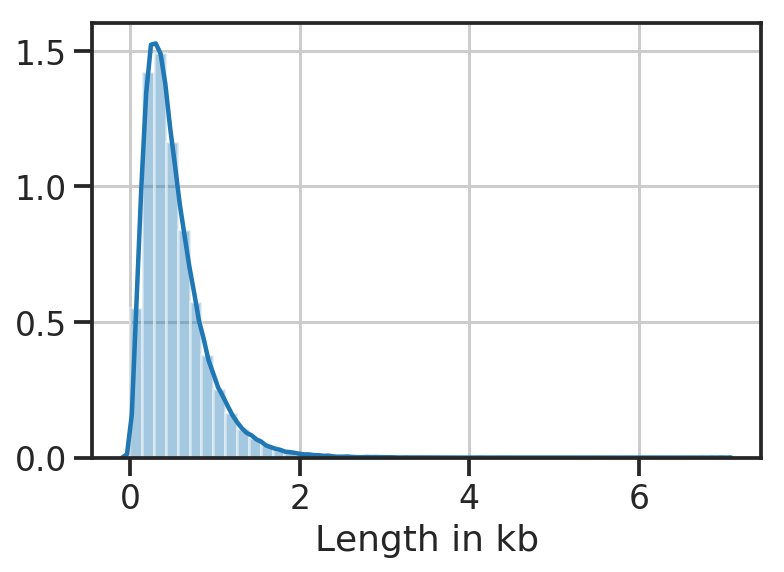

In [24]:

ens_list['length'] = ens_list['end'] - ens_list['start']
fig, ax = plt.subplots()
sns.distplot(ens_list['length'].values/1000, ax=ax)
ax.set_xlabel('Length in kb')
output_name = '22-length-distribution' 
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()


In [25]:
# full correlation

ti = time.time()

# gene 
_x_features = genes_list['gene_name'].values
_X = gene_rna_clsts.loc[_x_features, clusters_selected].values


# # enhancer
_y_features = ens_list['index'].values
_Y = enh_mcg_clsts.loc[:, clusters_selected].values # already selected 

# corr = snmcseq_utils.spearman_corrcoef(_X, _Y)[:len(_X), len(_X):]
print(_X.shape, _Y.shape)

# print(time.time()-ti)

(13828, 46) (107210, 46)


In [26]:
_X_ranks = snmcseq_utils.rank_rows(_X)
_Y_ranks = snmcseq_utils.rank_rows(_Y)

In [27]:
# more than 15 mins for ~500,000 enhancers

# tss and enhancer center: 500KB ~ 2KB
# to_evals - ens, gene, val, dist

KB = 1000
window_size = 2000*KB # (+500/-500)
inner_window_size = 4*KB #(+2/-2)
to_evals = [] 

ti = time.time()

# ens, gene
for idx, gene in genes_list.iterrows():
    if idx % 1000 == 0:
        print(idx, time.time()-ti)
    
    chrom, pos = gene['chrom'], gene['tss']
    if chrom in ['Y']:
        continue
    chrom_size = snmcseq_utils.get_chrom_lengths_mouse().loc[chrom]
    window = [max(0, pos-window_size/2), 
              min(chrom_size, pos+window_size/2)]
    window_exclude = [max(0, pos-inner_window_size/2),
                      min(chrom_size, pos+inner_window_size/2)
                     ]

    # get ens
    pos_enh = ens_list['center'] 
    cond = ((ens_list['chrom'] == chrom) 
             & (pos_enh >= window[0]) 
             & (pos_enh <= window[1])
             & ((pos_enh <= window_exclude[0]) | (pos_enh >= window_exclude[1]))
            )
    ens_include = [ens for ens in ens_list[cond]['index'].values if ens in _y_features]
    for ens in ens_include:
        to_evals.append((gene['gene_name'], ens))
to_evals = pd.DataFrame(to_evals, columns=['gene', 'ens'])

f = '/cndd/fangming/CEMBA/data/MOp_all/enhancers_may1/enhancers_june19/to_evals_0619.tsv'
print(to_evals.shape)
to_evals.head()
to_evals.to_csv(f, sep="\t", header=True, index=False)

0 0.0039882659912109375


/cndd/fangming/CEMBA/snmcseq_dev/snmcseq_utils.py:461: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  srs_gsize = pd.read_table(genome_size_fname, header=None, index_col=0, squeeze=True)


1000 24.818336009979248
2000 49.09213972091675
3000 73.66443204879761
4000 98.6558256149292
5000 123.17903995513916
6000 147.0130763053894
7000 170.85960483551025
8000 195.6534378528595
9000 219.38149547576904
10000 243.840758562088
11000 268.8435392379761
12000 292.72386407852173
13000 317.17423129081726
(1489021, 2)


In [28]:
f = '/cndd/fangming/CEMBA/data/MOp_all/enhancers_may1/enhancers_june19/to_evals_0619.tsv'
to_evals = pd.read_csv(f, sep="\t")
print(to_evals.shape)
to_evals.head()

(1489021, 2)


,gene,ens
0,0610009B22Rik,19297
1,0610009B22Rik,19298
2,0610009B22Rik,19299
3,0610009B22Rik,19300
4,0610009B22Rik,19304


In [29]:
ti = time.time()
# val, dist
_x_idx = snmcseq_utils.get_index_from_array(_x_features, to_evals['gene'].values)
_y_idx = snmcseq_utils.get_index_from_array(_y_features, to_evals['ens'].values)
to_evals['val'] = snmcseq_utils.vcorrcoef(_X_ranks[_x_idx], _Y_ranks[_y_idx]) 
to_evals['dist'] = np.abs(ens_list.set_index('index').loc[to_evals['ens'].values, 'center'].values 
                        - genes_list.set_index('gene_name').loc[to_evals['gene'].values, 'tss'].values 
                        )

print(time.time()-ti)
to_evals.head()

16.928736686706543


,gene,ens,val,dist
0,0610009B22Rik,19297,0.130681,974912
1,0610009B22Rik,19298,0.126364,971152
2,0610009B22Rik,19299,0.041381,945395
3,0610009B22Rik,19300,0.215048,943853
4,0610009B22Rik,19304,0.130311,880897


In [31]:
# # super enhancers

# # KB = 1000
# # window_size = 2000*KB # (+500/-500)
# # inner_window_size = 4*KB #(+2/-2)
# to_evals_shuffled = [] 

# ti = time.time()

# # shuffle gene_name label
# genes_list_shuffle = genes_list.copy()
# np.random.seed(1)
# genes_list_shuffle['gene_name'] = np.random.permutation(genes_list_shuffle['gene_name'].values)
# print(len(genes_list_shuffle))
# genes_list_shuffle.head()

# # ens, gene
# for idx, gene in genes_list_shuffle.iterrows():
#     if idx % 1000 == 0:
#         print(idx, time.time()-ti)
    
#     chrom, pos = gene['chrom'], gene['tss']
#     if chrom in ['Y']:
#         continue
#     chrom_size = snmcseq_utils.get_chrom_lengths_mouse().loc[chrom]
#     window = [max(0, pos-window_size/2), 
#               min(chrom_size, pos+window_size/2)]
#     window_exclude = [max(0, pos-inner_window_size/2),
#                       min(chrom_size, pos+inner_window_size/2)
#                      ]

#     # get ens
#     pos_enh = ens_list['center'] 
#     cond = ((ens_list['chrom'] == chrom) 
#              & (pos_enh >= window[0]) 
#              & (pos_enh <= window[1])
#              & ((pos_enh <= window_exclude[0]) | (pos_enh >= window_exclude[1]))
#             )
#     ens_include = [ens for ens in ens_list[cond]['index'].values if ens in _y_features]
#     for ens in ens_include:
#         to_evals_shuffled.append((gene['gene_name'], ens))
# to_evals_shuffled = pd.DataFrame(to_evals_shuffled, columns=['gene', 'ens'])

# print(len(to_evals_shuffled))

# f = '/cndd/fangming/CEMBA/data/MOp_all/enhancers_may1/enhancers_june19/to_evals_shuffled_0619.tsv'
# print(to_evals_shuffled.shape)
# to_evals_shuffled.to_csv(f, sep="\t", header=True, index=False)
# to_evals_shuffled.head()

f = '/cndd/fangming/CEMBA/data/MOp_all/enhancers_may1/enhancers_june19/to_evals_shuffled_0619.tsv'
to_evals_shuffled = pd.read_csv(f, sep="\t")
print(to_evals_shuffled.shape)
to_evals_shuffled.head()

(1489021, 2)


,gene,ens
0,Hist3h2a,19297
1,Hist3h2a,19298
2,Hist3h2a,19299
3,Hist3h2a,19300
4,Hist3h2a,19304


In [32]:
ti = time.time()
# val, dist
_x_idx = snmcseq_utils.get_index_from_array(_x_features, to_evals_shuffled['gene'].values)
_y_idx = snmcseq_utils.get_index_from_array(_y_features, to_evals_shuffled['ens'].values)
to_evals_shuffled['val'] = snmcseq_utils.vcorrcoef(_X_ranks[_x_idx], _Y_ranks[_y_idx]) 
to_evals_shuffled['dist'] = np.abs(ens_list.set_index('index').loc[to_evals_shuffled['ens'].values, 'center'].values 
                        - genes_list_shuffle.set_index('gene_name').loc[to_evals_shuffled['gene'].values, 'tss'].values 
                        )

print(time.time()-ti)
to_evals_shuffled.head()

16.82993769645691


,gene,ens,val,dist
0,Hist3h2a,19297,0.068763,974912
1,Hist3h2a,19298,-0.439655,971152
2,Hist3h2a,19299,-0.322603,945395
3,Hist3h2a,19300,-0.352328,943853
4,Hist3h2a,19304,-0.291274,880897


In [33]:
# mean within a distance bin
n = 100
_dist = np.linspace(0, window_size/(2*KB), n)
_tmp = to_evals.join(pd.qcut(to_evals['dist'], n, labels=False).to_frame('qcut')).groupby('qcut')['val']
_mval = _tmp.mean()
_stdval = _tmp.std()
_sizes = _tmp.size()
print(_dist.shape, _mval.shape)

(100,) (100,)


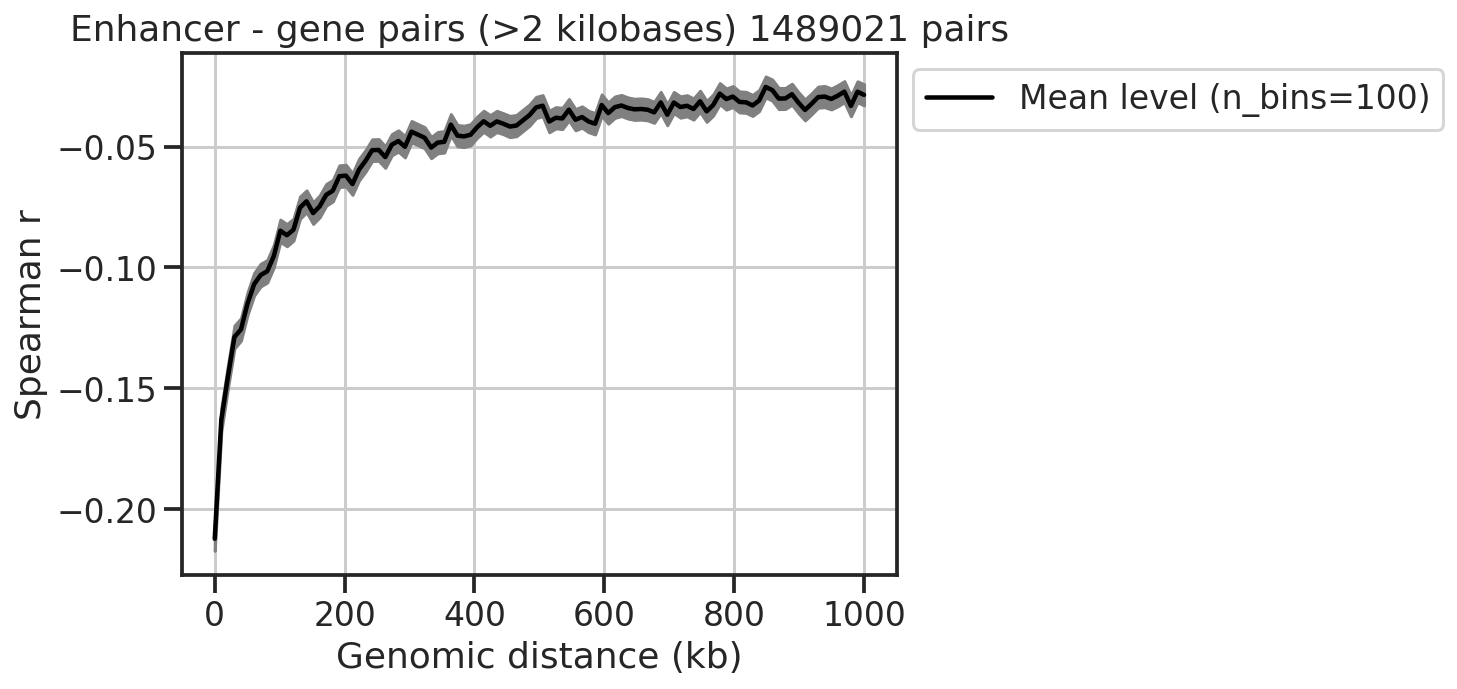

In [34]:
scale = 0.8
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(8*scale,6*scale))
    x = to_evals['dist'].values/1000, 
    y = to_evals['val'].values, 
   
    yerr = 1.96*_stdval/np.sqrt(_sizes)
    ax.plot(
        _dist, _mval,
#         yerr=yerr,
        '-',
        c='black',
        label='Mean level (n_bins={})'.format(n),
        markersize=5,
#         capsize=3,
    )
    
    ax.fill_between(_dist, _mval-yerr, _mval+yerr, color='gray')
    ax.legend(bbox_to_anchor=(1,1))
    ax.set_xlabel('Genomic distance (kb)')
    ax.set_ylabel('Spearman r')
    ax.set_title('Enhancer - gene pairs (>2 kilobases) {} pairs'.format(len(to_evals)))
    output_name = '23-dist-mean-r' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    plt.show()
    


### Statistical evaluation 
compute local FDR: 
- histogram -> density estimation (interpolate) -> cdf (cumsum), ratio of cdf
- quantile ranking (cdf) -> interpolate -> ratio of cdf

#### Setting up 

In [35]:
def bin_mean(x, y, bins):
    """Bin x according to bins, return bins, y_mean
    """
    # bin _x and mean_y
    _df = pd.DataFrame()
    _df['bin'] = np.digitize(_x, bins)
    _df['_y'] = _y
    _y_mean = _df.groupby('bin').mean()['_y']
    
    return bins[_y_mean.index], _y_mean.values

def fdr(x, x_bck, y_bck, x_fr, y_fr):
    """
    """
    return (np.interp(x, x_bck, y_bck))/(np.interp(x, x_fr, y_fr)+1e-6)

def pvalue(x, x_bck, y_bck):
    """
    """
    return np.interp(x, x_bck, y_bck)


In [36]:
# randomly sample many genes and enhancers
ti = time.time()

p = 0.05
np.random.seed(0)
_y_selected_idx = np.arange(len(_y_features))[np.random.rand(len(_y_features))<p]
_x_selected_idx = np.arange(len(_x_features))

_x_selected_features = _x_features[_x_selected_idx]
_y_selected_features = _y_features[_y_selected_idx]

# same chrom or not
x_chroms = df_genes_v2.reindex(_x_selected_features)['chrom'].values
y_chroms = regions.set_index('index').reindex(_y_selected_features)['chrom'].values

corr = snmcseq_utils.spearman_corrcoef(_X[_x_selected_idx], _Y[_y_selected_idx])[:len(_x_selected_idx), len(_x_selected_idx):]
corr_cis_mask = np.zeros_like(corr)
for i, x_chrom in enumerate(x_chroms):
    for j, y_chrom in enumerate(y_chroms):
        if x_chrom == y_chrom:
            corr_cis_mask[i,j] = 1
            
corr_cis = corr[corr_cis_mask.nonzero()]
# corr_noncis = corr[(~corr_cis_mask.astype(bool)).nonzero()] 
print(time.time()-ti)

33.151413440704346


In [149]:
labels = ['All',
          'Same chrom',
        '<500kb',
        '<200kb',
        '<100kb',
        '<100kb shuffled',
         ]

corr_tracks = [corr.flatten(),
       corr_cis,
       to_evals.loc[to_evals['dist']<=500*KB, 'val'].values,
       to_evals.loc[to_evals['dist']<=200*KB, 'val'].values,
       to_evals.loc[to_evals['dist']<=100*KB, 'val'].values,
       to_evals_shuffled.loc[to_evals_shuffled['dist']<=100*KB, 'val'].values,
      ]

subsample_rates = [0.01,
                  0.1,
                  1,
                  1,
                  1,
                  1,
                 ]

np.random.seed(0)
corr_tracks = [corr_tracks[i][np.random.rand(len(corr_tracks[i])) < subsample_rates[i]] 
               for i in range(len(corr_tracks))]

colors = ['C0', 'C1', 'C2', 'C4', 'C3', 'C5']

In [150]:
# FDR

bins = np.linspace(-1, 1, 200)
bins_eval = np.linspace(-1, 1, 2000)

# background
_x = np.sort(corr_tracks[0])
_y = np.arange(len(_x))/len(_x)
x_smooth_bck, y_smooth_bck = bin_mean(_x, _y, bins)
# pvalue
pvalues = pvalue(bins_eval, x_smooth_bck, y_smooth_bck)
to_evals['pvalues'] = pvalue(to_evals['val'].values, x_smooth_bck, y_smooth_bck)

# fore-ground - 2
fdrs = []
for corr_track, track_name in zip(corr_tracks[2:5], labels[2:5]):
    _x = np.sort(corr_track)
    _y = np.arange(len(_x))/len(_x)
    x_smooth_fr0, y_smooth_fr0 = bin_mean(_x, _y, bins)
    # ratio 2
    fdrs.append(fdr(bins_eval, x_smooth_bck, y_smooth_bck, x_smooth_fr0, y_smooth_fr0))
    to_evals['fdr-'.format(track_name)] = fdr(to_evals['val'].values, x_smooth_bck, y_smooth_bck, x_smooth_fr0, y_smooth_fr0)

In [166]:
### vary FDR
_tracks = collections.OrderedDict({
    '2-100': to_evals.loc[((to_evals['dist']>2*KB) & 
                        (to_evals['dist']<=100*KB)), 'val'].values,
    '100-200': to_evals.loc[((to_evals['dist']>100*KB) & 
                        (to_evals['dist']<=200*KB)), 'val'].values,
    '200-300': to_evals.loc[((to_evals['dist']>200*KB) & 
                        (to_evals['dist']<=300*KB)), 'val'].values,
    '300-400': to_evals.loc[((to_evals['dist']>300*KB) & 
                        (to_evals['dist']<=400*KB)), 'val'].values,
    '400-500': to_evals.loc[((to_evals['dist']>400*KB) & 
                        (to_evals['dist']<=500*KB)), 'val'].values,
})

res_num_sig = []
for track_name, corr_track in _tracks.items():
    _x = np.sort(corr_track)
    _y = np.arange(len(_x))/len(_x)
    x_smooth_fr, y_smooth_fr = bin_mean(_x, _y, bins)
    fdr_new = fdr(corr_track, x_smooth_bck, y_smooth_bck, x_smooth_fr, y_smooth_fr)
    num_sig = np.sum(fdr_new < 0.20)
    res_num_sig.append({'track_name': track_name, 
                        'num_sig': num_sig,
                       })
    
res_num_sig = pd.DataFrame(res_num_sig)
print(res_num_sig.shape)
res_num_sig.head()

(5, 2)


,num_sig,track_name
0,7259,2-100
1,395,100-200
2,99,200-300
3,1,300-400
4,0,400-500


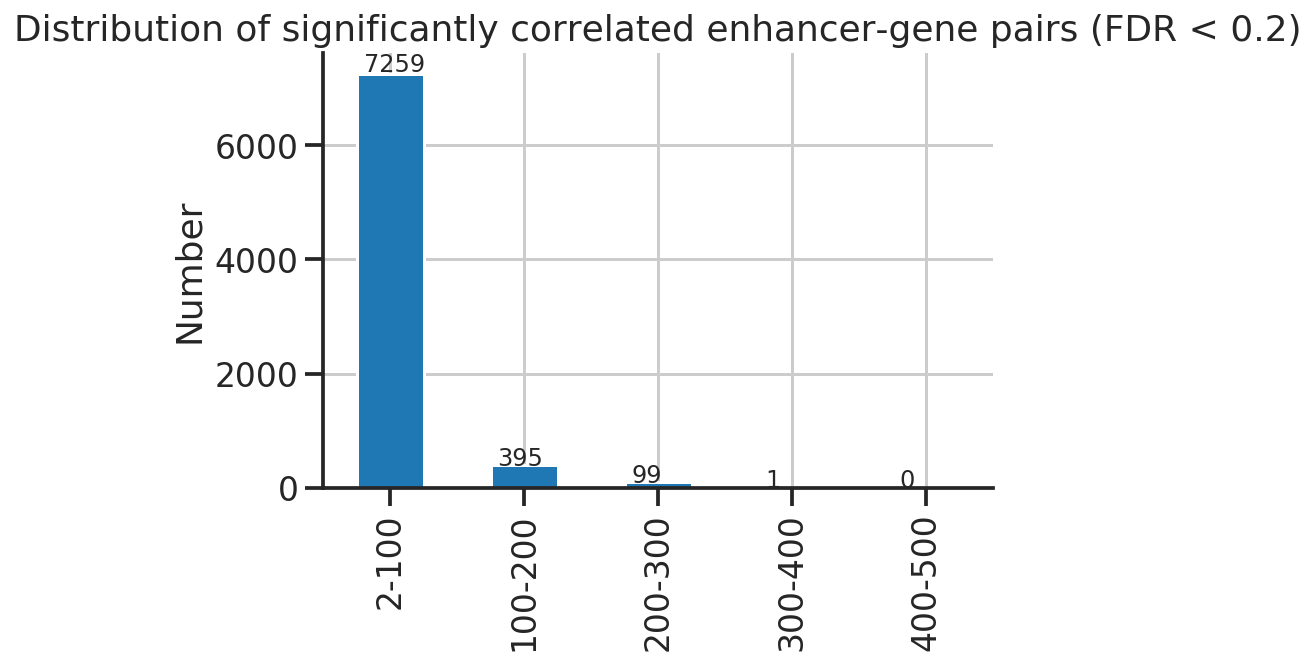

In [180]:
output_name = '35_FDR_number'
fig, ax = plt.subplots()
res_num_sig.plot.bar(ax=ax, legend=False)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.05, p.get_height() * 1.005), fontsize=12)
ax.set_ylabel('Number')
sns.despine(ax=ax)
ax.set_title('Distribution of significantly correlated enhancer-gene pairs (FDR < 0.2)')
ax.set_xticklabels(res_num_sig['track_name'].values)
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()

#### Test individual pairs

In [128]:
to_evals.head()

,gene,ens,val,dist,fdr-500k,fdr-200k,fdr-100k,pvalues
0,0610009B22Rik,19297,0.130681,974912,0.948606,0.913872,0.888444,0.61487
1,0610009B22Rik,19298,0.126364,971152,0.947457,0.912052,0.886185,0.61487
2,0610009B22Rik,19299,0.041381,945395,0.923879,0.873182,0.837132,0.61487
3,0610009B22Rik,19300,0.215048,943853,0.966064,0.942963,0.925887,0.61487
4,0610009B22Rik,19304,0.130311,880897,0.948508,0.913717,0.888251,0.61487


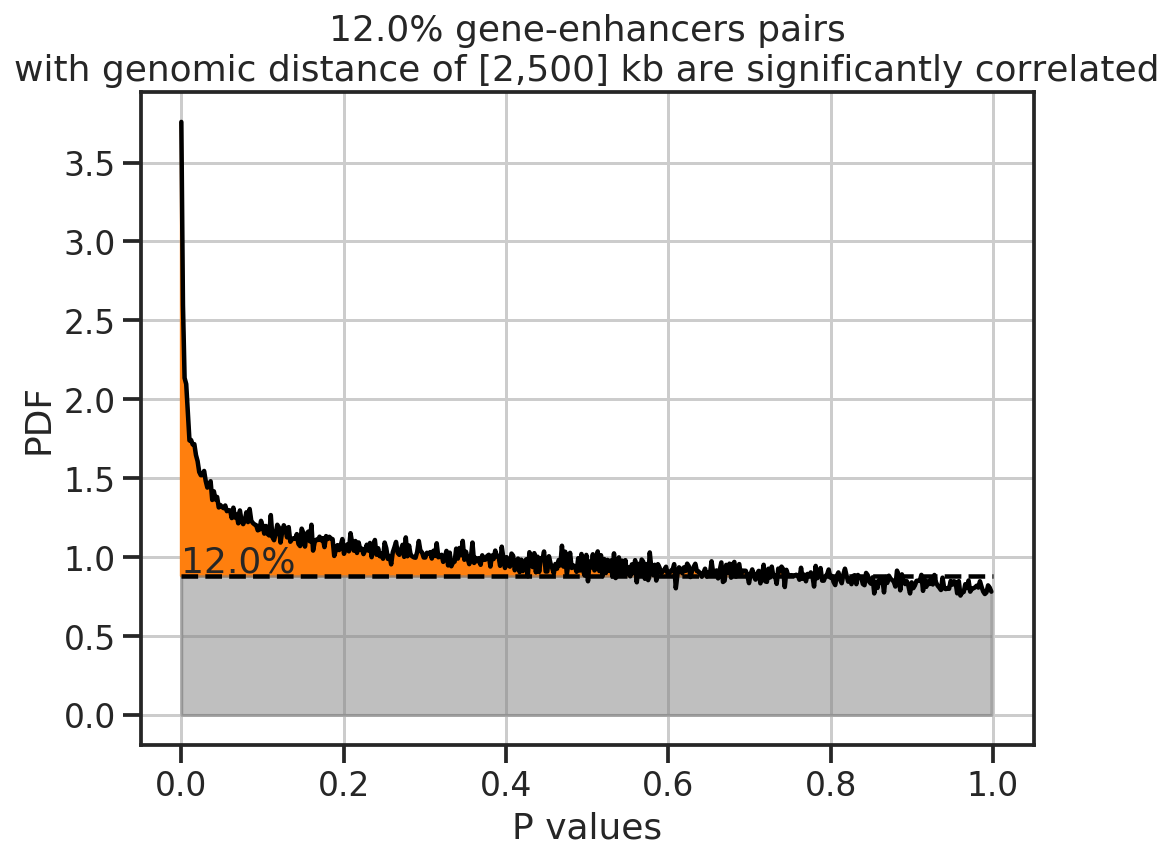

In [40]:
# plot pvalues
output_name = '20-fraction-of-h1-one-example'

y = to_evals.loc[to_evals['dist']<500*KB, 'pvalues'].sort_values().values
bin_n = 500
bin_edges = np.linspace(0, 1, bin_n)
bin_width = 1.0/bin_n
bin_counts, bin_edges = np.histogram(y, bin_edges)
y_norm = bin_counts/(bin_width*bin_counts.sum())
null_level = y_norm[-int(0.50*bin_n):].mean()
# frac_tp = np.sum(np.maximum(y_norm-null_level, 0)*bin_width)
frac_tp = 1 - null_level 


fig, ax = plt.subplots(figsize=(8,6))
ax.plot(bin_edges[:-1], y_norm, color='k')
ax.plot([0, 1], [null_level]*2, linestyle='--', color='k')
ax.fill_between(bin_edges[:-1], null_level, y_norm, 
                where=y_norm>null_level, alpha=1, color='C1')
ax.fill_between(bin_edges[:-1], 0, np.minimum(y_norm, null_level), alpha=0.5, color='grey')
ax.text(0, null_level+0.2*(1-null_level), 
        "{:.1f}%".format(frac_tp*100), 
        fontsize=18)


ax.set_xlabel('P values')
ax.set_ylabel('PDF')
ax.set_title("{:.1f}% gene-enhancers pairs\nwith genomic distance of [2,500] kb are significantly correlated".format(frac_tp*100))
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()

In [41]:
frac_tps = []
num_tps = []
dists_kb = np.hstack([[10, 20, 50], np.arange(100, 1000+1, 100)]) 

for idx in np.arange(len(dists_kb)):
    dist_kb = dists_kb[idx]
    if idx == 0:
        cond = (to_evals['dist'] < dist_kb*KB)
    else:
        dist_kb_prev = dists_kb[idx-1]
        cond = ((to_evals['dist'] < dist_kb*KB) & 
                (to_evals['dist'] >= dist_kb_prev*KB))
    
    y = to_evals.loc[cond, 'pvalues'].values
    bin_n = 500
    bin_edges = np.linspace(0, 1, bin_n)
    bin_width = 1.0/bin_n
    bin_counts, bin_edges = np.histogram(y, bin_edges)
    y_norm = bin_counts/(bin_width*bin_counts.sum())
    null_level = y_norm[-int(0.50*bin_n):].mean()
    frac_tp = 1 - null_level 
    frac_tps.append(frac_tp)
    num_tps.append(len(y))


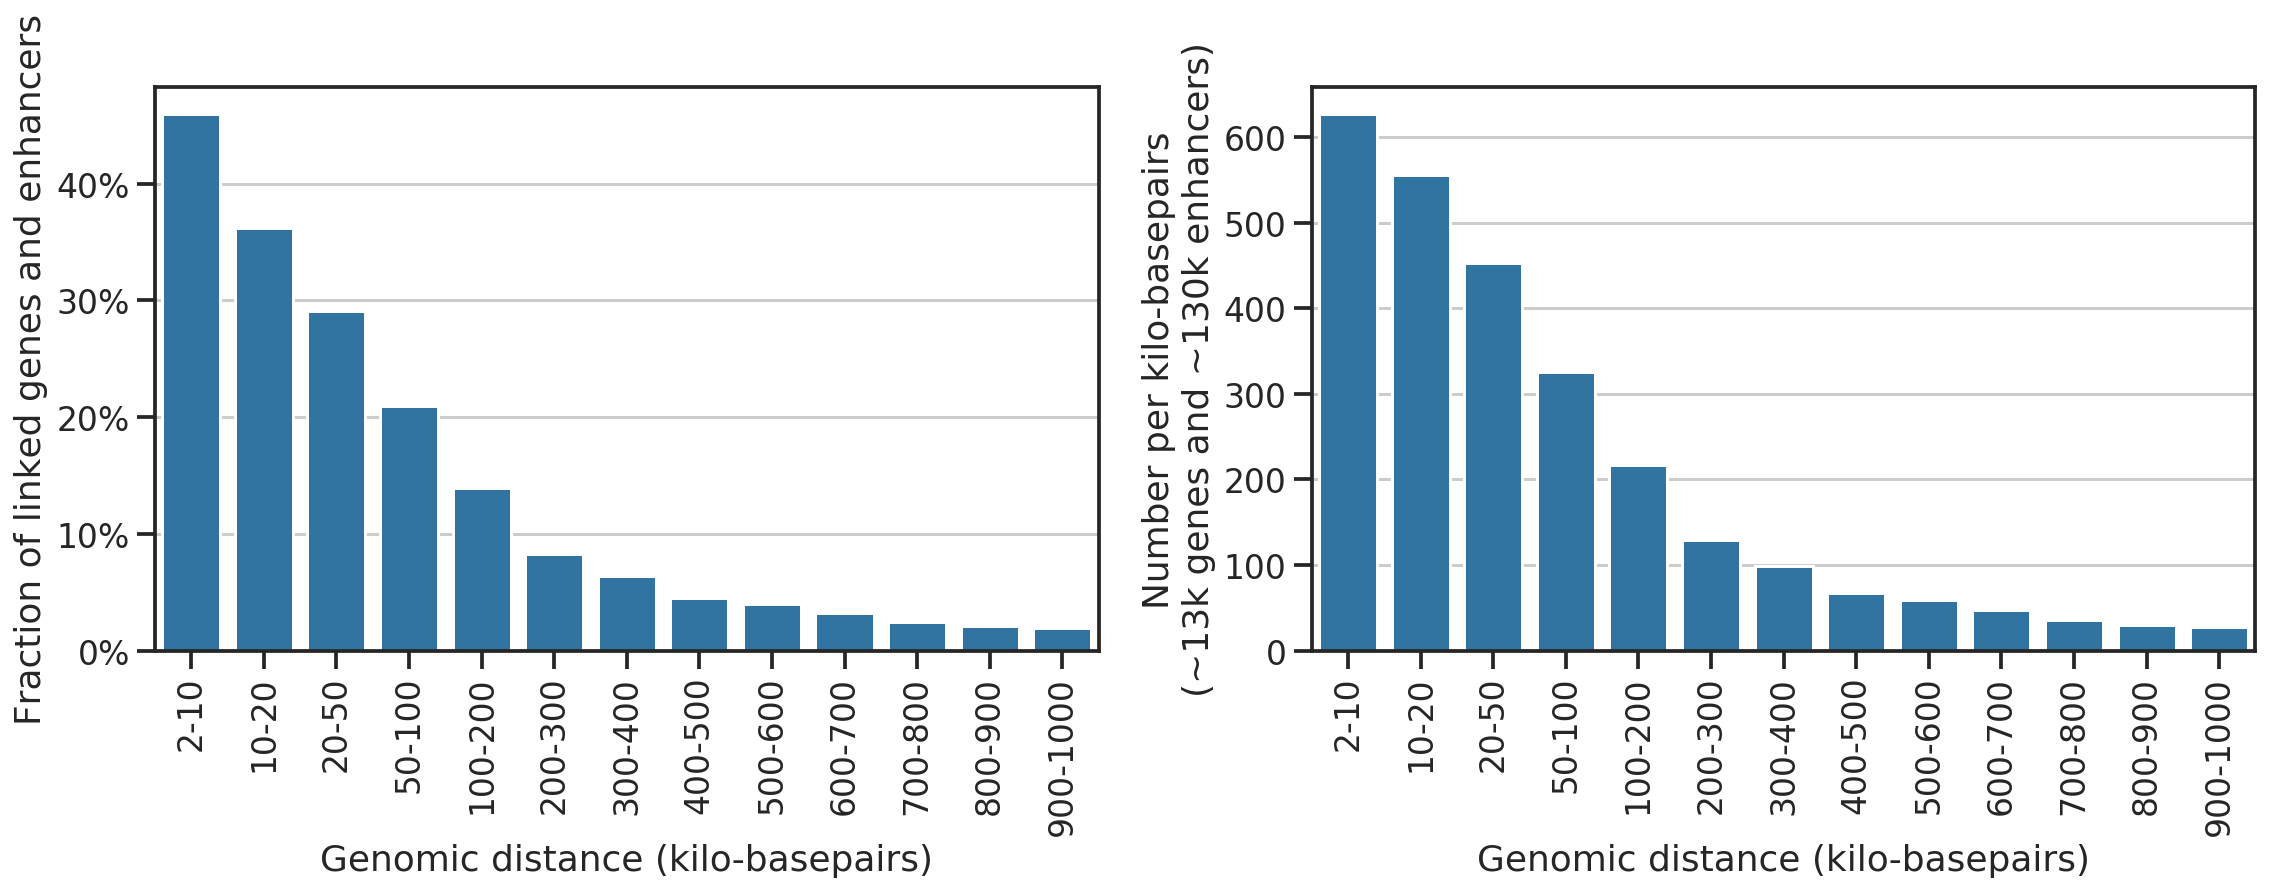

In [42]:
output_name = '21-fraction-of-h1-summary'

df_plot = pd.DataFrame(np.vstack([dists_kb, frac_tps]).T, columns=['x', 'y'])
dists_kb_plot = np.hstack([[2], dists_kb])
df_plot['x_formatted'] = ["{}-{}".format(dists_kb_plot[i], dists_kb_plot[i+1]) for i in range(len(dists_kb))]
df_plot['length'] = [dists_kb_plot[i+1] - dists_kb_plot[i] for i in range(len(dists_kb))]
df_plot['num'] = np.array(num_tps)*np.array(frac_tps)
df_plot['num_norm'] = df_plot['num']/df_plot['length']

fig, axs = plt.subplots(1, 2, figsize=(8*2,6), sharex=True)
ax = axs[0]
sns.barplot(x='x_formatted', y='y', data=df_plot, color='C0', ax=ax)
ax.set_xlabel('Genomic distance (kilo-basepairs)')
ax.set_ylabel('Fraction of linked genes and enhancers')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(PercentFormat) 

ax = axs[1]
sns.barplot(x='x_formatted', y='num_norm', data=df_plot, color='C0', ax=ax)
ax.set_xlabel('Genomic distance (kilo-basepairs)')
ax.set_ylabel('Number per kilo-basepairs\n(~13k genes and ~130k enhancers)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

fig.tight_layout()
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()



In [43]:
# significant ones
sig_cond = (
    ((to_evals['fdr-100k']<0.05) & (to_evals['dist']<100*KB)) |
    ((to_evals['fdr-200k']<0.05) & (to_evals['dist']<200*KB)) |
    ((to_evals['fdr-500k']<0.05) & (to_evals['dist']<500*KB))
)

top_sig = to_evals[sig_cond].sort_values(['val']) #.head(30)

# top_sig = to_evals[(to_evals['fdr-200k']<0.05) & (to_evals['dist']<200*KB)].sort_values(['fdr-200k', 'val']) #.head(30)
# top_sig = to_evals[(to_evals['fdr-500k']<0.05) & (to_evals['dist']<500*KB)].sort_values(['fdr-100k', 'val']) #.head(30)

top_sig = pd.merge(top_sig, ens_list, left_on='ens', right_on='index')
top_sig_genes = top_sig.groupby('gene').size().sort_values(ascending=False).index.values
top_sig_ens = top_sig.groupby('ens').size().sort_values(ascending=False).index.values

n_pair, n_enh, n_gene = len(top_sig), len(top_sig_ens), len(top_sig_genes)
print('{} significantly correlated enhancer-gene pairs\n{}/{} enhancers {}/{} genes'
    .format(n_pair, n_enh, len(_y_features), n_gene, len(_x_features)) 
     )
top_sig.head()

1025 significantly correlated enhancer-gene pairs
987/107210 enhancers 432/13828 genes


,gene,ens,val,dist,fdr-500k,fdr-200k,fdr-100k,pvalues,index,chrom,start,end,center,length
0,Camk2a,62294,-0.926118,57699,0.181847,0.087944,0.044687,0.000001,62294,18,60983066,60983569,60983317,503
1,Atp2b1,15037,-0.925378,73606,0.166829,0.081020,0.041059,0.000001,15037,10,98986550,98989474,98988012,2924
2,Rbm24,33176,-0.922911,5925,0.130816,0.064177,0.032313,0.000001,33176,13,46423290,46425429,46424359,2139
3,Atp2b1,15029,-0.922664,46839,0.128051,0.062870,0.031639,0.000001,15029,10,98960514,98961977,98961245,1463
4,Atp2b1,15032,-0.920937,58974,0.111551,0.055026,0.027609,0.000001,15032,10,98972616,98974144,98973380,1528


#### Plots 

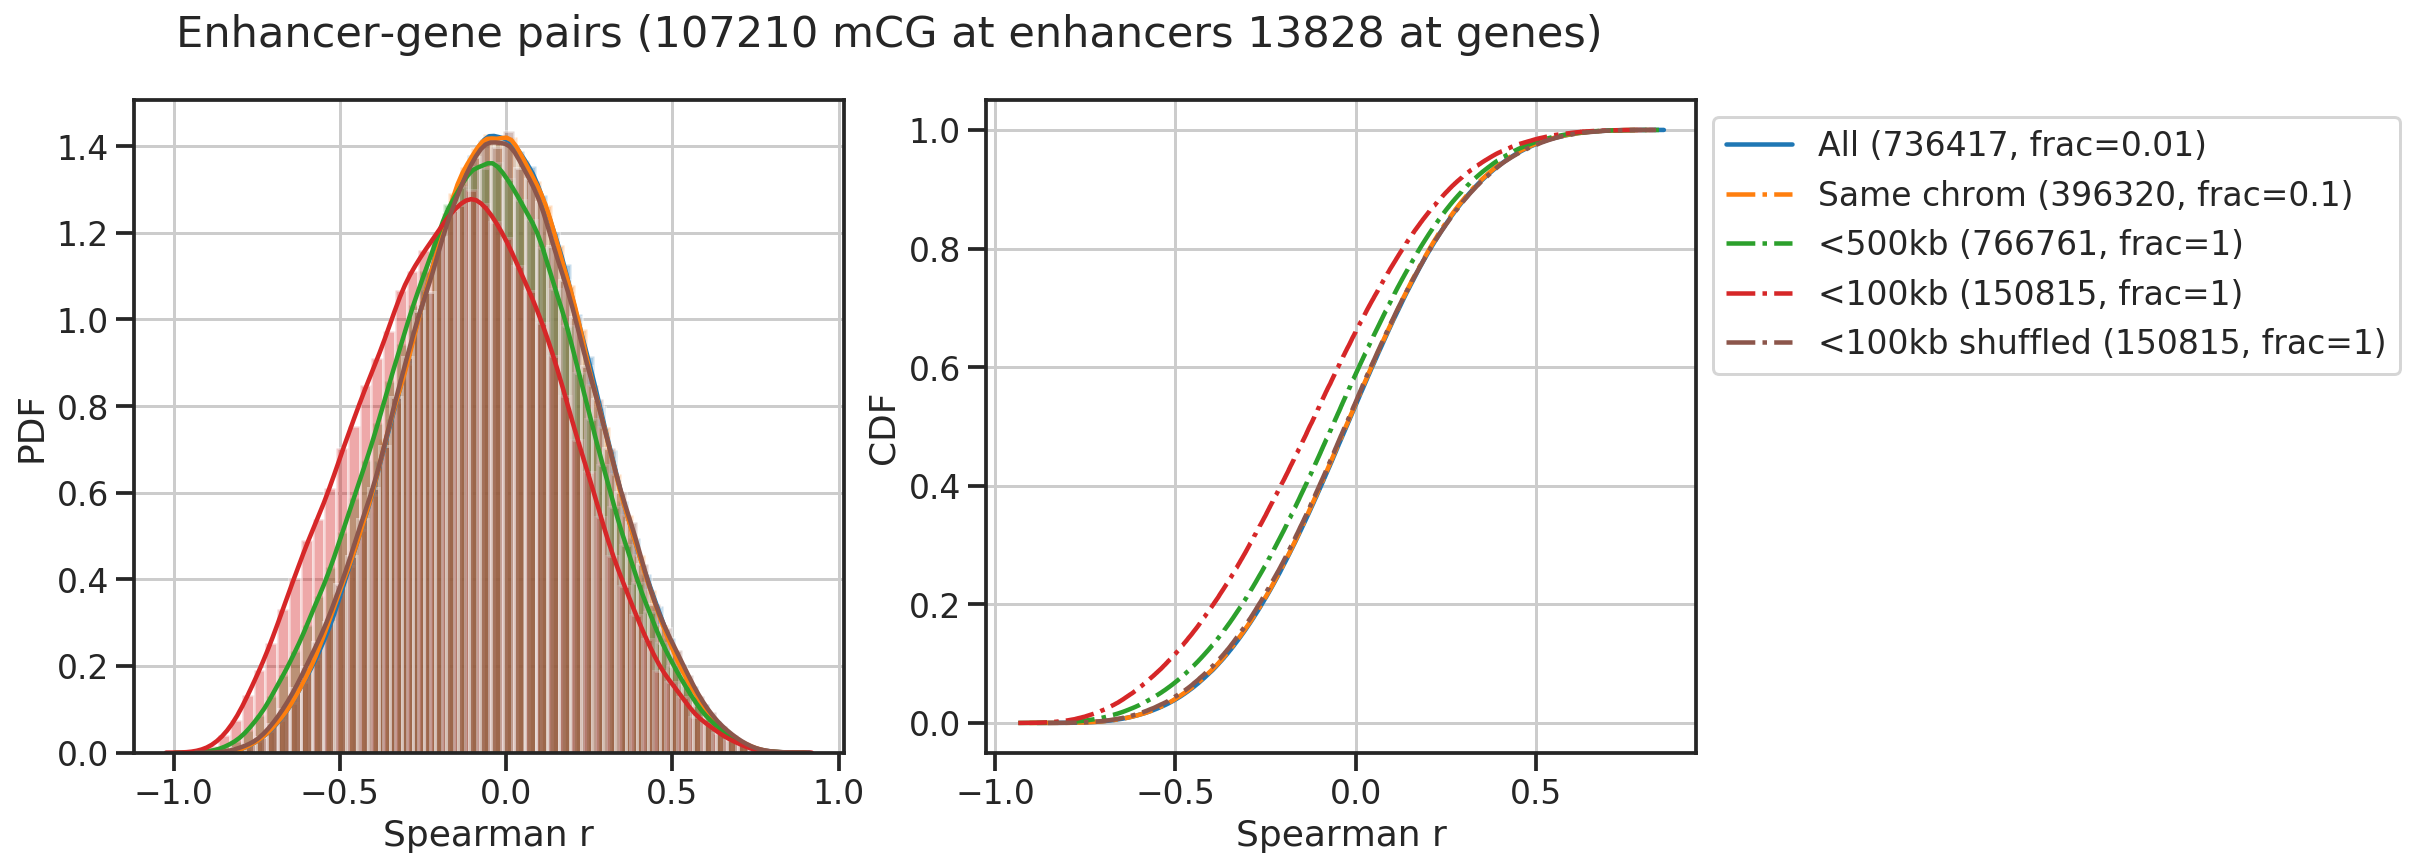

In [44]:
with sns.plotting_context('talk'):
    fig, axs = plt.subplots(1, 2, figsize=(7*2,6))
    ax = axs[0]
    for _x, label, color in zip(corr_tracks, labels, colors):
        if label == '<200kb':
            continue
        sns.distplot(np.sort(_x), ax=ax, 
                     label='{} ({})'.format(label, len(_x)),
                     color=color,
                    )

    ax.set_xlabel('Spearman r')
    ax.set_ylabel('PDF')
    
    ax = axs[1]
    for _x, label, color, subsample_rate in zip(corr_tracks, labels, colors, subsample_rates):
        if label == '<200kb':
            continue
            
        linestyle = '-.'
        if label == 'All':
            linestyle = '-'
        ax.plot(np.sort(_x), np.arange(len(_x))/len(_x), 
                linestyle,
                label='{} ({}, frac={})'.format(label, len(_x), subsample_rate),
                color=color,
               )

    ax.legend(bbox_to_anchor=(1,1))
    ax.set_xlabel('Spearman r')
    ax.set_ylabel('CDF')
    
    fig.suptitle('Enhancer-gene pairs ({} mCG at enhancers {} at genes)'.format(len(_y_features), len(_x_features)), 
                )
    
    output_name = '24-distribution-different-categories' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
#     fig.tight_layout()
    plt.show()

In [126]:
# from matplotlib.patches import Rectangle
# with sns.plotting_context('talk'):
#     # inner box
# #     xmin_1, xmax_1, ymin_1, ymax_1 = -0.8, 0.8, 0, 1 
# #     xmin, xmax, ymin, ymax = -0.75, -0.4, 0.01, 0.3 
#     xmin, xmax, ymin, ymax = -0.9, -0.4, 0.01, 0.3 
    
#     fig, axs = plt.subplots(1, 2, figsize=(7*2, 6*1))
#     ax = axs[0]
#     ax.plot(bins_eval, fdr0, label=labels[2], color=colors[2])
#     ax.plot(bins_eval, fdr1, label=labels[3], color=colors[3])
#     ax.plot(bins_eval, fdr2, label=labels[4], color=colors[4])
# #     ax.set_xlim([xmin_1, xmax_1])
# #     ax.set_ylim([ymin_1, ymax_1])
#     ax.legend()
#     ax.set_xlabel('Spearman r')
#     ax.set_ylabel('FDR')
    
#     ax.xaxis.set_major_locator(plt.MaxNLocator(3))
#     ax.yaxis.set_major_locator(plt.MaxNLocator(4))
#     ax.add_patch(Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=None, color='black', linestyle='-.'))

#     ax = axs[1]
#     ax.plot(bins_eval, fdr0, label=labels[2], color=colors[2])
#     ax.plot(bins_eval, fdr1, label=labels[3], color=colors[3])
#     ax.plot(bins_eval, fdr2, label=labels[4], color=colors[4])
#     ax.set_xlim([xmin, xmax])
#     ax.set_ylim([ymin, ymax])
    
#     ax.axhline(0.05, color='black', linestyle='--')
#     ax.xaxis.set_major_locator(plt.MaxNLocator(6))
#     ax.yaxis.set_major_locator(plt.MaxNLocator(6))

#     output_name = '25-fdr-categories' 
#     fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
#     plt.show()

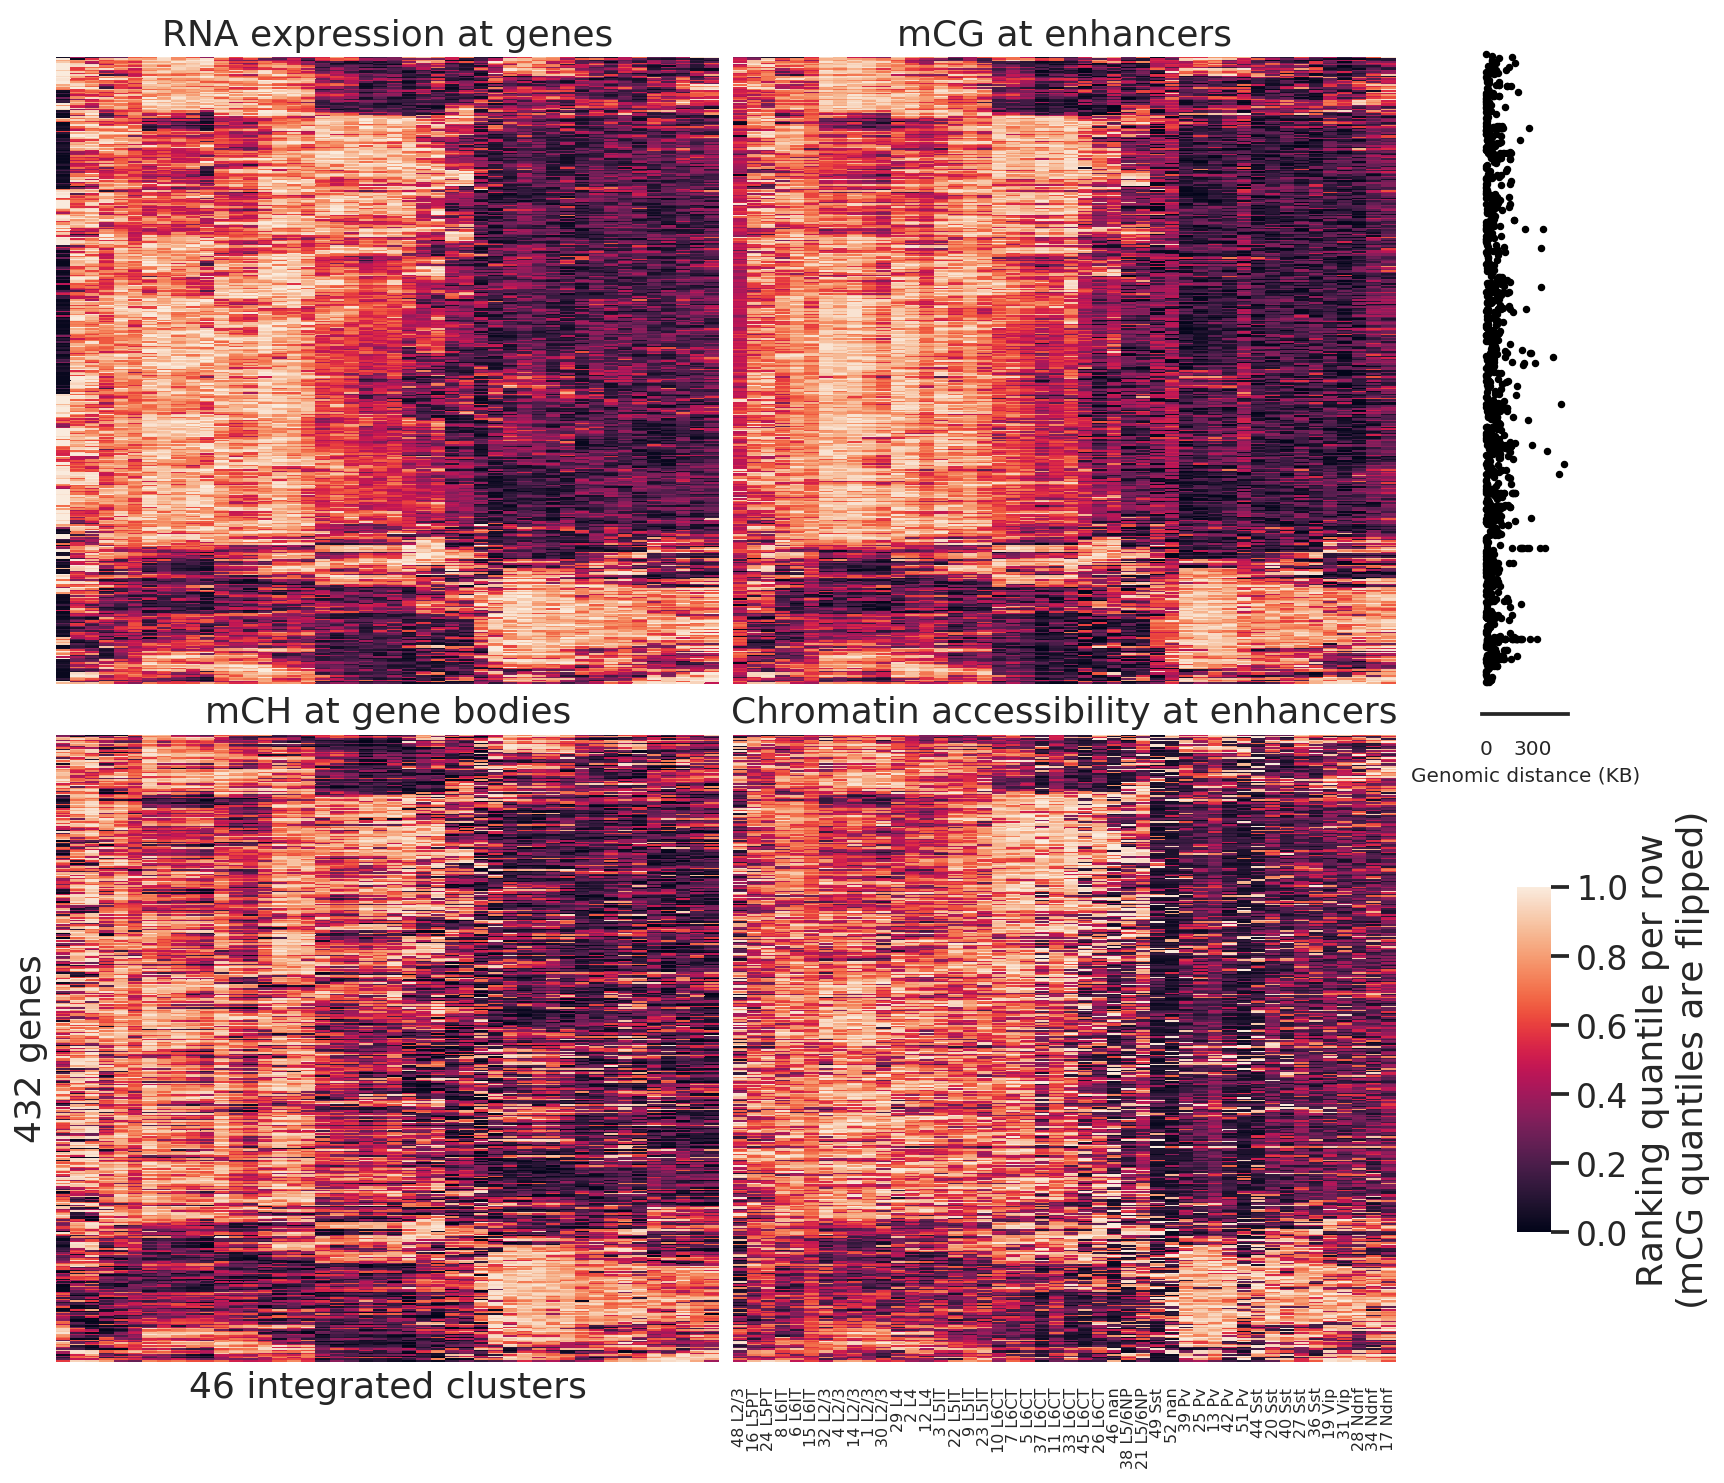

In [46]:
# heatmap of gene by cluster
# set_matplotlib_formats('pdf')

def zscore(x):
    return (x - np.mean(x))/np.std(x)

cmap = 'rocket'

# rna at genes 
rna_mat = gene_rna_clsts.loc[top_sig_genes, clusters_selected]
rna_mat_norm = rna_mat.rank(pct=True, axis=1) #.apply(zscore, axis=1)

# row gene
Z = sch.linkage(rna_mat_norm, method='average', metric='euclidean', optimal_ordering=True)
dn = sch.dendrogram(Z, no_plot=True)

# col clst
Z = sch.linkage(rna_mat_norm.T, method='average', metric='euclidean', optimal_ordering=True)
dn_clst = sch.dendrogram(Z, no_plot=True)

# 
genes_ordered = rna_mat_norm.index.values[dn['leaves']]
ens_ordered = top_sig.set_index('gene').loc[genes_ordered]

# mCH at genes
mch_mat = gene_mch_clsts.reindex(genes_ordered).loc[:, clusters_selected]

# mC at enhancers 
mcc_mat = enh_mcg_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
mcc_mat['gene'] = ens_ordered.index.values
mcc_mat = mcc_mat.groupby('gene').mean().loc[genes_ordered]

# ATAC at enhancers
atac_mat = enh_atac_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
atac_mat['gene'] = ens_ordered.index.values
atac_mat = atac_mat.groupby('gene').mean().loc[genes_ordered]
    
with sns.plotting_context('talk'), sns.axes_style('white'):
    fig, axs = plt.subplots(2, 2, figsize=(6*2,6*2))
    cbar_ax = fig.add_axes([.97, .2, .02, .2])
    
    # distance panel
    dist_ax = fig.add_axes([.95, .5, .05, .4])
    ax = dist_ax
    
    dists = top_sig.set_index('gene').loc[genes_ordered,  'dist']/KB
    genes_idx = snmcseq_utils.get_index_from_array(genes_ordered, dists.index.values)
    
    ax.scatter(dists.values, genes_idx, s=5, c='black')
    ax.invert_yaxis()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticklabels([])
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(2))
    ax.xaxis.set_tick_params(labelsize=10)
    ax.set_xlabel('Genomic distance (KB)', fontsize=10)
    
    
    ax = axs[0,0]
    g = sns.heatmap(rna_mat_norm.iloc[dn['leaves'], dn_clst['leaves']],
#                     xticklabels=clusters_selected_labels[dn_clst['leaves']], 
                    xticklabels=False,
                    yticklabels=False,
                    cbar=False,
                    vmin=0, vmax=1,
                    ax=ax,
                    cmap=cmap,
                   )
    ax.set_title('RNA expression at genes')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = axs[0,1]
    g = sns.heatmap((1-mcc_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']], #, #.apply(zscore, axis=1), 
                    yticklabels=False,
                    # xticklabels=clusters_selected_labels[dn_clst['leaves']], 
                    xticklabels=False,
                    vmin=0, vmax=1,
                    cbar_ax=cbar_ax,
                    cbar_kws={'fraction': 0.05, 
                              'label': 'Ranking quantile per row\n(mCG quantiles are flipped)',
                             }, 
                    cmap=cmap,
                    ax=ax)
    ax.set_title('mCG at enhancers')
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    ax = axs[1,0]
    g = sns.heatmap((1-mch_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']], #, #.apply(zscore, axis=1), 
                    yticklabels=False,
                    xticklabels=False, 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    ax=ax)
    
    ax.set_title('mCH at gene bodies')
    ax.set_xlabel('{} integrated clusters'.format(len(dn_clst['leaves'])))
    ax.set_ylabel('{} genes'.format(len(dn['leaves'])))
    
    
    ax = axs[1,1]
    g = sns.heatmap(atac_mat.rank(axis=1, pct=True).iloc[:, dn_clst['leaves']], #, #.apply(zscore, axis=1), 
                    yticklabels=False,
                    xticklabels=clusters_selected_labels[dn_clst['leaves']], 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    ax=ax)
    
    ax.set_title('Chromatin accessibility at enhancers')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_ylabel('')
    ax.set_xlabel('')
    fig.subplots_adjust(wspace=0.02, hspace=0.08)
    
#     fig.tight_layout()
    output_name = '26-heatmap-example-enhancer-genes' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    plt.show()

### Compare with nearest gene 

In [47]:
# get nn gene information
top_sig['nearest_gene'] = regions_info.set_index('index').loc[top_sig['ens'].values, 'gene_name'].values

n_nngenes = (top_sig['gene'] == top_sig['nearest_gene']).sum()
print("{}/{}={:.2f} pairs are from the nearest genes, {} non-trivial pairs"
      .format(n_nngenes, n_pair, n_nngenes/n_pair, n_pair-n_nngenes))
    
nontr_top_sig = top_sig.loc[(top_sig['gene'] != top_sig['nearest_gene'])].sort_values('dist', ascending=False)
print(nontr_top_sig.shape)
nontr_top_sig.head()

814/1025=0.79 pairs are from the nearest genes, 211 non-trivial pairs
(211, 15)


,gene,ens,val,dist,fdr-500k,fdr-200k,fdr-100k,pvalues,index,chrom,start,end,center,length,nearest_gene
212,Sept5,49959,-0.854949,498347,0.032616,0.015134,0.008977,0.000008,49959,16,18131165,18132017,18131591,852,Rtn4r
214,Camkk2,100916,-0.856183,478873,0.030214,0.014013,0.008288,0.000007,100916,5,123257913,123258651,123258282,738,Wdr66
258,Slc24a4,29733,-0.850015,424966,0.040407,0.018782,0.011248,0.000012,29733,12,102553374,102554025,102553699,651,Chga
51,Fgfr1op2,111076,-0.889238,389195,0.021130,0.010757,0.005930,0.000001,111076,6,146965951,146966845,146966398,894,Ppfibp1
267,Nptx1,24334,-0.849275,359644,0.041378,0.019237,0.011534,0.000012,24334,11,119905647,119909148,119907397,3501,Chmp6


In [48]:
# nontr_top_sig.groupby('gene').size().sort_values(ascending=False)

In [49]:
# browser link
for j, (i, row) in enumerate(nontr_top_sig.iterrows()):
    if j > 30:
        break
    print(row['gene'], snmcseq_utils.gen_annoj_url(row['chrom'], row['center'], 30, file='index_Ens100_Fangming.html'))


Sept5 https://brainome.ucsd.edu/annoj_private/CEMBA/index_Ens100_Fangming.html?assembly=16&position=18131591&bases=30
Camkk2 https://brainome.ucsd.edu/annoj_private/CEMBA/index_Ens100_Fangming.html?assembly=5&position=123258282&bases=30
Slc24a4 https://brainome.ucsd.edu/annoj_private/CEMBA/index_Ens100_Fangming.html?assembly=12&position=102553699&bases=30
Fgfr1op2 https://brainome.ucsd.edu/annoj_private/CEMBA/index_Ens100_Fangming.html?assembly=6&position=146966398&bases=30
Nptx1 https://brainome.ucsd.edu/annoj_private/CEMBA/index_Ens100_Fangming.html?assembly=11&position=119907397&bases=30
Kcnk4 https://brainome.ucsd.edu/annoj_private/CEMBA/index_Ens100_Fangming.html?assembly=19&position=7287013&bases=30
Atf6 https://brainome.ucsd.edu/annoj_private/CEMBA/index_Ens100_Fangming.html?assembly=1&position=170520327&bases=30
Grasp https://brainome.ucsd.edu/annoj_private/CEMBA/index_Ens100_Fangming.html?assembly=15&position=100913633&bases=30
Camk2a https://brainome.ucsd.edu/annoj_private/CE

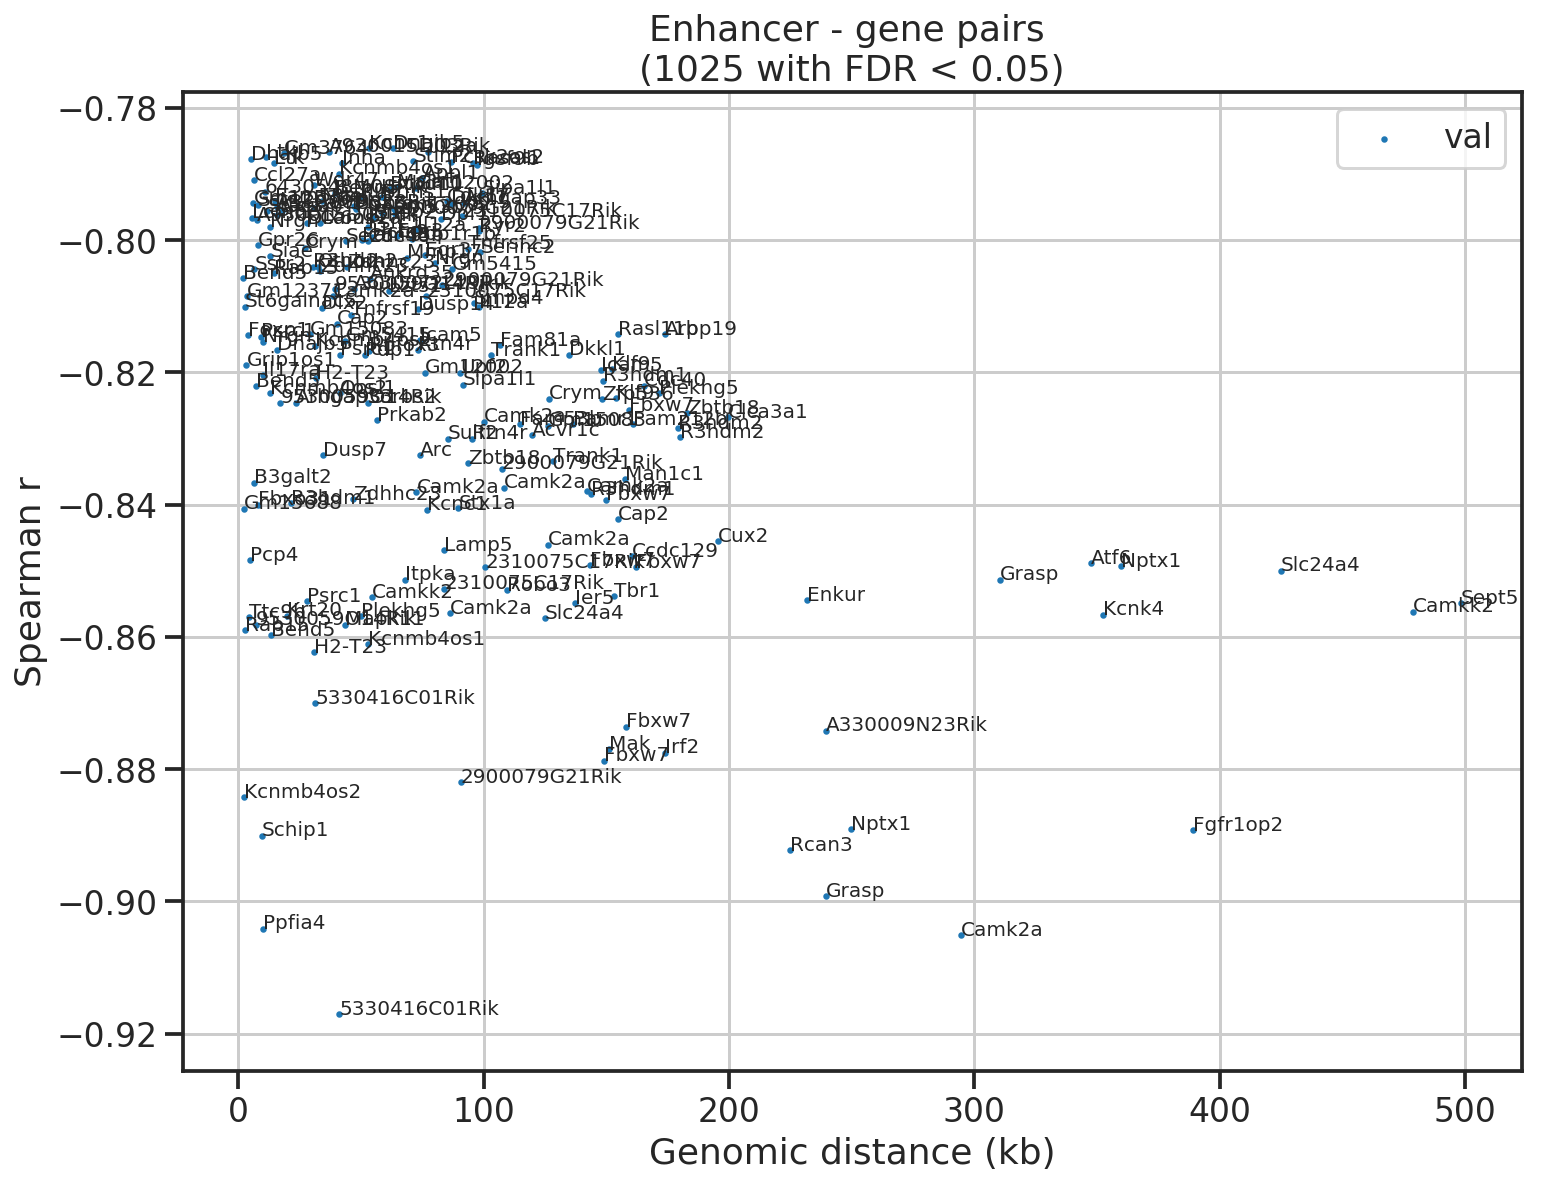

In [50]:
# vals 
scale = 1.5
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(8*scale,6*scale))
        
#     # plot mean
#     ax.plot(
#         _dist, _mval,
#         c='gray',
#         label='Mean level (n_bins={})'.format(n),
#     )
    
    # plot significant 
    _df = nontr_top_sig 
    ax.scatter(_df['dist']/1000, _df['val'], s=3)
        
    # plot significant 
    _df = nontr_top_sig 
    texts = []
    for idx, row in _df.iterrows():
        texts.append(
            ax.text(
                row['dist']/1000, 
                row['val'], 
                "{}".format(row['gene']),
                fontsize=10,
        ))
#     adjust_text(texts) 
    
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel('Genomic distance (kb)')
    ax.set_ylabel('Spearman r')
    ax.set_title('Enhancer - gene pairs \n({} with FDR < 0.05)'.format(len(top_sig)))
    output_name = '27-example-enhancer-genes' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    plt.show()
    


### Compare with CICERO findings 

In [51]:
# CICERO enhancers -> genes
f = '/cndd/fangming/CEMBA/data/MOp_cicero/distal_gene/cicero_enhancer_gene_mm10_nochr.bed'
cicero_to_gene = pd.read_csv(f, sep='\t', header=None, names=['chrom', 'start', 'end', 'index', 'gene'])
cicero_to_gene['chrom'] = cicero_to_gene['chrom'].apply(lambda x: 'chr'+str(x))
print(cicero_to_gene.shape)
cicero_to_gene.head()

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1283006, 5)


,chrom,start,end,index,gene
0,chr1,98117479,98117798,0,Pam
1,chr1,98119472,98120309,1,7SK
2,chr1,98119472,98120309,2,B230216N24Rik
3,chr1,98119472,98120309,3,Pam
4,chr1,98128413,98131088,4,B230216N24Rik


In [52]:
# enhancers -> CICERO enhancers 
f = '/cndd/fangming/CEMBA/data/MOp_all/enhancers_may1/enhancers_june19/allclusters_intersect_peaks_dmrs.chr.cicero_overlap.bed'
ens_to_cicero = pd.read_csv(f, sep="\t", header=None, 
                            names=['chrom', 'start', 'end', 'name', 
                                    'chrom_cicero', 'start_cicero', 'end_cicero', 'overlap'
                                   ])
print(ens_to_cicero.shape)
ens_to_cicero.head()


(48286, 8)


,chrom,start,end,name,chrom_cicero,start_cicero,end_cicero,overlap
0,chr1,3367941,3368352,L4,chr1,3368065,3368627,287
1,chr1,3369768,3369975,L4,chr1,3369351,3369979,207
2,chr1,3391457,3391804,L4,chr1,3391766,3392639,38
3,chr1,3552547,3552835,Pv,chr1,3552476,3552818,271
4,chr1,4572356,4572534,L4,chr1,4571193,4572423,67


In [53]:
# enhancers -> cicero enhancers -> cicero_genes # long, a few minutes
_cicero = cicero_to_gene.set_index(['chrom', 'start', 'end'])
def get_gene_from_cicero(row, cicero):
    """
    """
    chrom, start, end = row[['chrom_cicero', 'start_cicero', 'end_cicero']].tolist()
    genes = cicero.loc[(chrom, start, end), 'gene'].values
    return genes
    
ens_to_cicero['gene_cicero'] = ens_to_cicero.apply(lambda x: get_gene_from_cicero(x, _cicero), axis=1)
print(ens_to_cicero.shape)
ens_to_cicero.head()

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/pandas/core/indexing.py:1494: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


(48286, 9)


,chrom,start,end,name,chrom_cicero,start_cicero,end_cicero,overlap,gene_cicero
0,chr1,3367941,3368352,L4,chr1,3368065,3368627,287,"[Gm1992, Xkr4]"
1,chr1,3369768,3369975,L4,chr1,3369351,3369979,207,"[Gm1992, Xkr4]"
2,chr1,3391457,3391804,L4,chr1,3391766,3392639,38,[Xkr4]
3,chr1,3552547,3552835,Pv,chr1,3552476,3552818,271,[Gm1992]
4,chr1,4572356,4572534,L4,chr1,4571193,4572423,67,"[Gm16041, Gm17100, Lypla1, Mrpl15, Sox17, Tcea..."


In [54]:
# Compare with our prediction
top_sig_chr = top_sig.copy() 
top_sig_chr['chrom'] = top_sig_chr['chrom'].apply(lambda x: 'chr'+str(x))

comp_cicero = pd.merge(top_sig_chr, ens_to_cicero, on=['chrom', 'start', 'end'])
print(top_sig_chr.shape, ens_to_cicero.shape, comp_cicero.shape)
comp_cicero.head()

(1025, 15) (48286, 9) (644, 21)


,gene,ens,val,dist,fdr-500k,fdr-200k,fdr-100k,pvalues,index,chrom,...,end,center,length,nearest_gene,name,chrom_cicero,start_cicero,end_cicero,overlap,gene_cicero
0,Atp2b1,15037,-0.925378,73606,0.166829,0.081020,0.041059,0.000001,15037,chr10,...,98989474,98988012,2924,Atp2b1,L5PT,chr10,98986292,98986669,119,"[Atp2b1, Dusp6, Galnt4, Poc1b]"
1,Atp2b1,15037,-0.925378,73606,0.166829,0.081020,0.041059,0.000001,15037,chr10,...,98989474,98988012,2924,Atp2b1,L5PT,chr10,98988858,98989315,457,[Dusp6]
2,Rbm24,33176,-0.922911,5925,0.130816,0.064177,0.032313,0.000001,33176,chr13,...,46425429,46424359,2139,Rbm24,L2_3,chr13,46423817,46424049,232,"[Cap2, Rbm24]"
3,Atp2b1,15029,-0.922664,46839,0.128051,0.062870,0.031639,0.000001,15029,chr10,...,98961977,98961245,1463,Atp2b1,L6IT,chr10,98960850,98962660,1127,"[Atp2b1, Dusp6, Galnt4, Gm16239, Phxr2, Poc1b]"
4,Atp2b1,15032,-0.920937,58974,0.111551,0.055026,0.027609,0.000001,15032,chr10,...,98974144,98973380,1528,Atp2b1,L5PT,chr10,98973109,98973726,617,"[Atp2b1, Dusp6, Phxr2, Poc1b]"


In [55]:
def check_agree(row):
    """
    """
    return (row['gene'] in row['gene_cicero'].tolist())

comp_cicero['agree?'] = comp_cicero.apply(check_agree, axis=1)
n_genes_avg = comp_cicero['gene_cicero'].apply(len).mean()

n_overlap = len(comp_cicero)
n_agree = comp_cicero['agree?'].sum()
n_test = comp_cicero.shape[0]
print(
    "{}/{}={:.2f} enhancer-gene pairs whose enhancers overlap with CICERO enhancers, {}/{}={:.2f} of them agree with CICERO prediction."
    .format(n_overlap, n_pair, n_overlap/n_pair, n_agree, n_test, n_agree/n_test))

comp_cicero[comp_cicero['agree?']].head()

644/1025=0.63 enhancer-gene pairs whose enhancers overlap with CICERO enhancers, 532/644=0.83 of them agree with CICERO prediction.


,gene,ens,val,dist,fdr-500k,fdr-200k,fdr-100k,pvalues,index,chrom,...,center,length,nearest_gene,name,chrom_cicero,start_cicero,end_cicero,overlap,gene_cicero,agree?
0,Atp2b1,15037,-0.925378,73606,0.166829,0.081020,0.041059,0.000001,15037,chr10,...,98988012,2924,Atp2b1,L5PT,chr10,98986292,98986669,119,"[Atp2b1, Dusp6, Galnt4, Poc1b]",True
2,Rbm24,33176,-0.922911,5925,0.130816,0.064177,0.032313,0.000001,33176,chr13,...,46424359,2139,Rbm24,L2_3,chr13,46423817,46424049,232,"[Cap2, Rbm24]",True
3,Atp2b1,15029,-0.922664,46839,0.128051,0.062870,0.031639,0.000001,15029,chr10,...,98961245,1463,Atp2b1,L6IT,chr10,98960850,98962660,1127,"[Atp2b1, Dusp6, Galnt4, Gm16239, Phxr2, Poc1b]",True
4,Atp2b1,15032,-0.920937,58974,0.111551,0.055026,0.027609,0.000001,15032,chr10,...,98973380,1528,Atp2b1,L5PT,chr10,98973109,98973726,617,"[Atp2b1, Dusp6, Phxr2, Poc1b]",True
6,Slc1a2,73276,-0.915140,27855,0.070820,0.036521,0.018941,0.000001,73276,chr2,...,102686514,756,Slc1a2,L4,chr2,102685478,102686434,298,"[Apip, Fjx1, Gm13872, Pamr1, Pdhx, Slc1a2]",True


### nearest genes vs CICERO? 

- significant genes
- nearest genes
- agreed with cicero

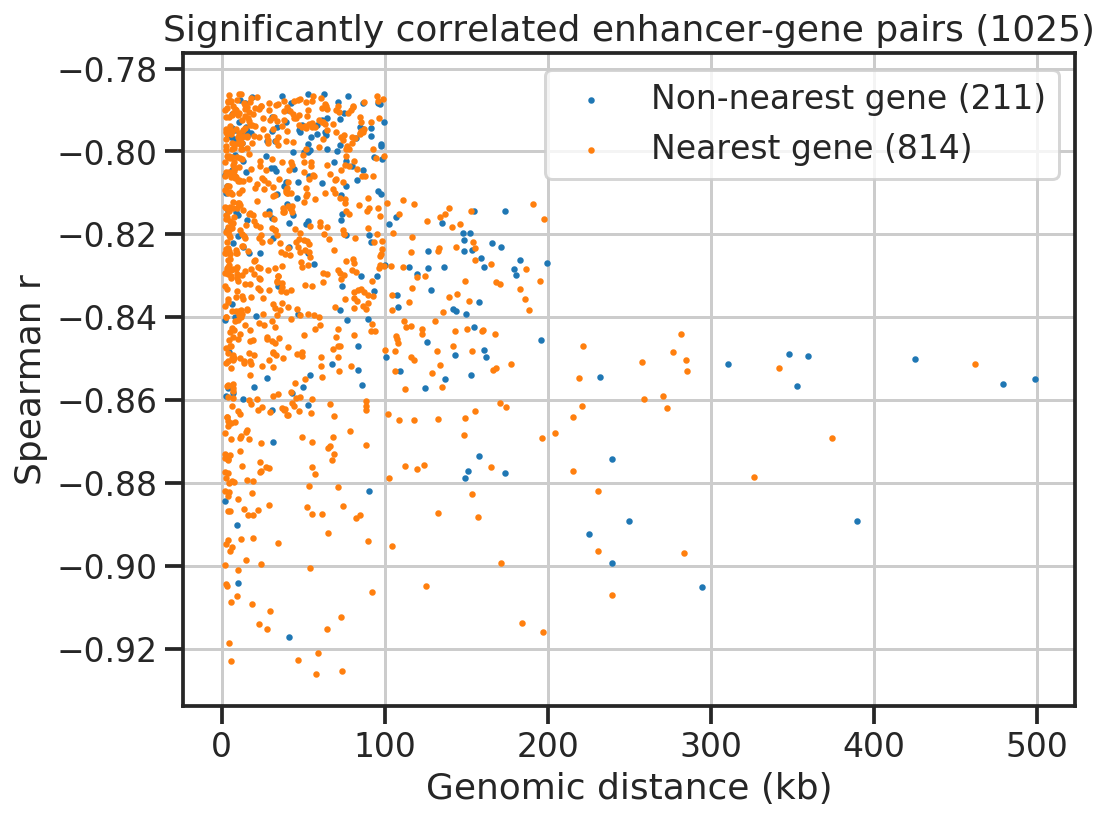

In [56]:
scale=1
fig, ax = plt.subplots(figsize=(8*scale, 6*scale))

# plot sig 
_df = top_sig[top_sig['gene']!=top_sig['nearest_gene']] 
n = len(_df)
ax.scatter(
    _df['dist']/1000, 
    _df['val'], 
    s=3,
    color='C0',
    alpha=1,
    label='Non-nearest gene ({})'.format(n),
)

# explained by nearest genes
# plot sig 
_df = top_sig[top_sig['gene']==top_sig['nearest_gene']] 
n = len(_df)
ax.scatter(
    _df['dist']/1000, 
    _df['val'], 
    s=3,
    color='C1',
    alpha=1,
    label='Nearest gene ({})'.format(n),
)


ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Genomic distance (kb)')
ax.set_ylabel('Spearman r')
ax.set_title('Significantly correlated enhancer-gene pairs ({})'.format(len(top_sig)))
plt.show()



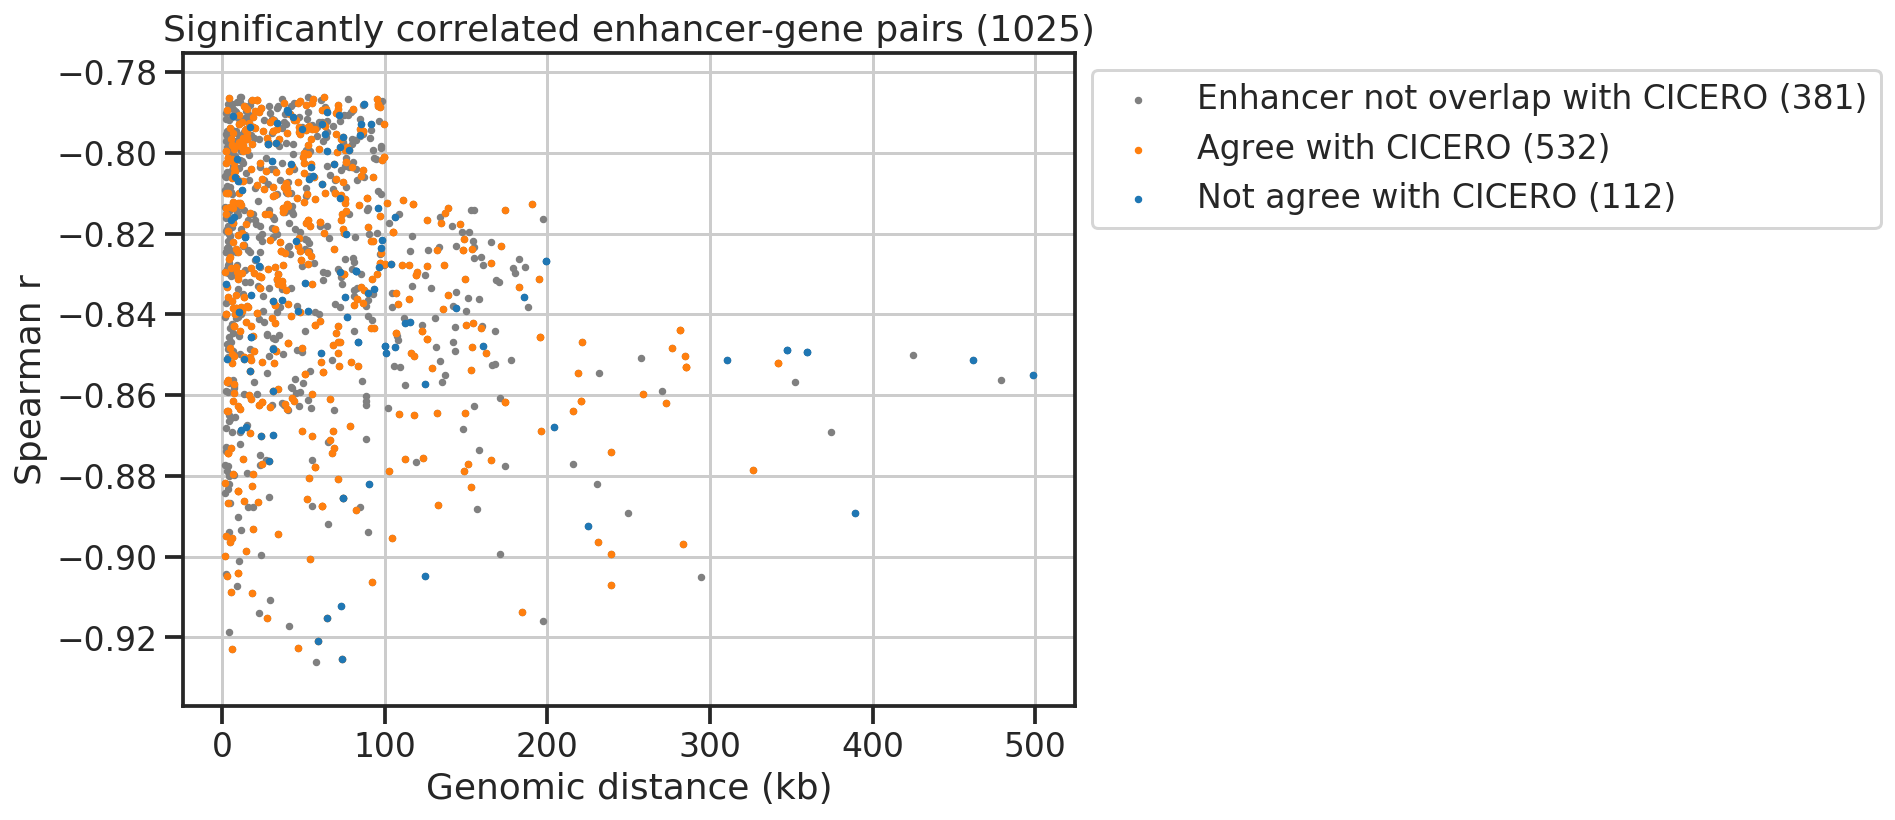

In [57]:
scale=1
fig, ax = plt.subplots(figsize=(8*scale, 6*scale))

s = 5 
# plot sig 
_df = top_sig 
n = len(_df) - len(comp_cicero)
ax.scatter(
    _df['dist']/1000, 
    _df['val'], 
    s=s,
    color='grey',
    alpha=1,
    label='Enhancer not overlap with CICERO ({})'.format(n),
)

# agree
_df = comp_cicero[comp_cicero['agree?']]
n = len(_df)
ax.scatter(
    _df['dist']/1000, 
    _df['val'], 
    s=s,
    color='C1',
    alpha=1,
    label='Agree with CICERO ({})'.format(n),
)

# not agree
_df = comp_cicero[~comp_cicero['agree?']]
n = len(_df)
ax.scatter(
    _df['dist']/1000, 
    _df['val'], 
    s=s,
    color='C0',
    alpha=1,
    label='Not agree with CICERO ({})'.format(n),
)

ax.legend(bbox_to_anchor=(1,1))

ax.set_xlabel('Genomic distance (kb)')
ax.set_ylabel('Spearman r')
ax.set_title('Significantly correlated enhancer-gene pairs ({})'.format(len(top_sig)))
plt.show()


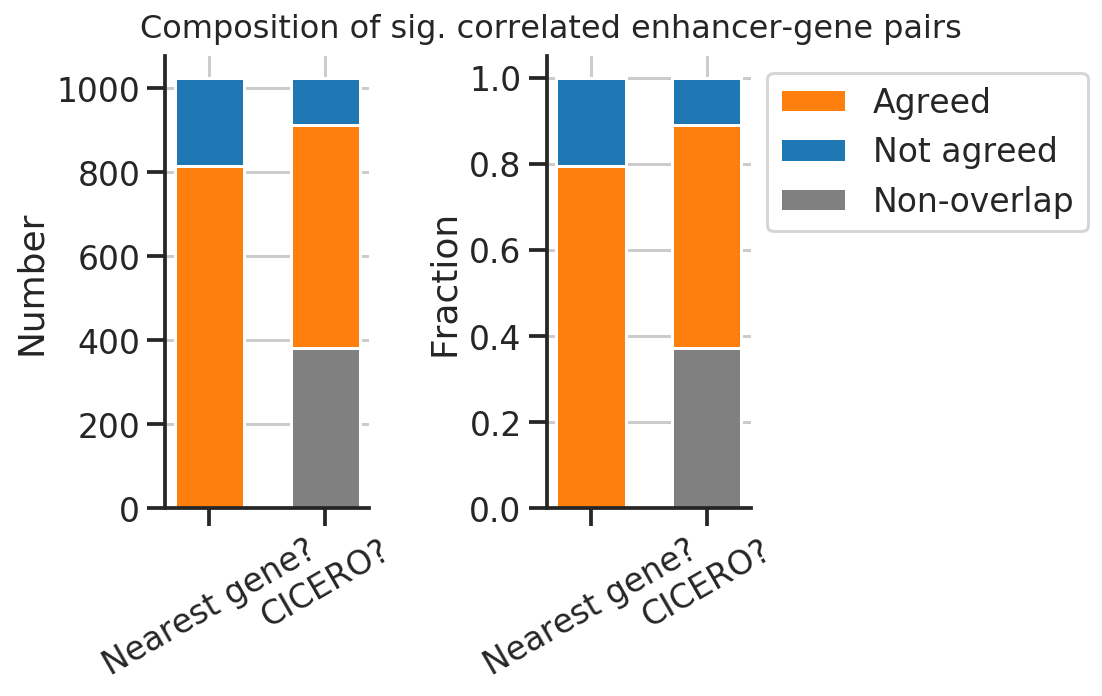

In [58]:
# numbers 
track1 = [0, 
          len(top_sig[top_sig['gene']==top_sig['nearest_gene']]), 
          len(top_sig[top_sig['gene']!=top_sig['nearest_gene']]),
         ]
track1_colors = ['C1', 'C0']
track1_labels = ['Agreed', 'Not agreed']
track2 = [0,
          len(top_sig) - len(comp_cicero), 
          len(comp_cicero[comp_cicero['agree?']==True]),
          len(comp_cicero[comp_cicero['agree?']==False]),
         ]
track2_colors = ['grey', 'C1', 'C0']
track2_labels = ['Non-overlap', 'Agreed', 'Not agreed']

with sns.plotting_context('talk'):
    fig, axs = plt.subplots(1, 2, figsize=(4*2,5))
    ax = axs[0]
    for i in range(len(track1)-1):
        color = track1_colors[i]
        ax.bar(0, track1[i+1], width=0.6, bottom=np.cumsum(track1)[i], color=color, label=track1_labels[i])
    for i in range(len(track2)-1):
        color = track2_colors[i]
        ax.bar(1, track2[i+1], width=0.6, bottom=np.cumsum(track2)[i], color=color, label=track2_labels[i])
    ax.set_xticklabels(['', 'Nearest gene?', 'CICERO?'], rotation=30)
    ax.set_ylabel('Number')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    
# plot 2 fraction 
track1 = np.array(track1)
track1 = track1/track1.sum()

track2 = np.array(track2)
track2 = track2/track2.sum()

with sns.plotting_context('talk'):
    ax = axs[1]
    for i in range(len(track1)-1):
        color = track1_colors[i]
        ax.bar(0, track1[i+1], width=0.6, bottom=np.cumsum(track1)[i], color=color, label=track1_labels[i])

    for i in range(len(track2)-1):
        color = track2_colors[i]
        ax.bar(1, track2[i+1], width=0.6, bottom=np.cumsum(track2)[i], color=color, label=track2_labels[i])
    ax.set_xticklabels(['', 'Nearest gene?', 'CICERO?'], rotation=30)
    ax.set_ylabel('Fraction')
    snmcseq_utils.nondup_legends(ax, bbox_to_anchor=(1,1))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    fig.suptitle('Composition of sig. correlated enhancer-gene pairs', fontsize=16)
    output_name = '28-compare-to-nngenes-cicero' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    fig.tight_layout()

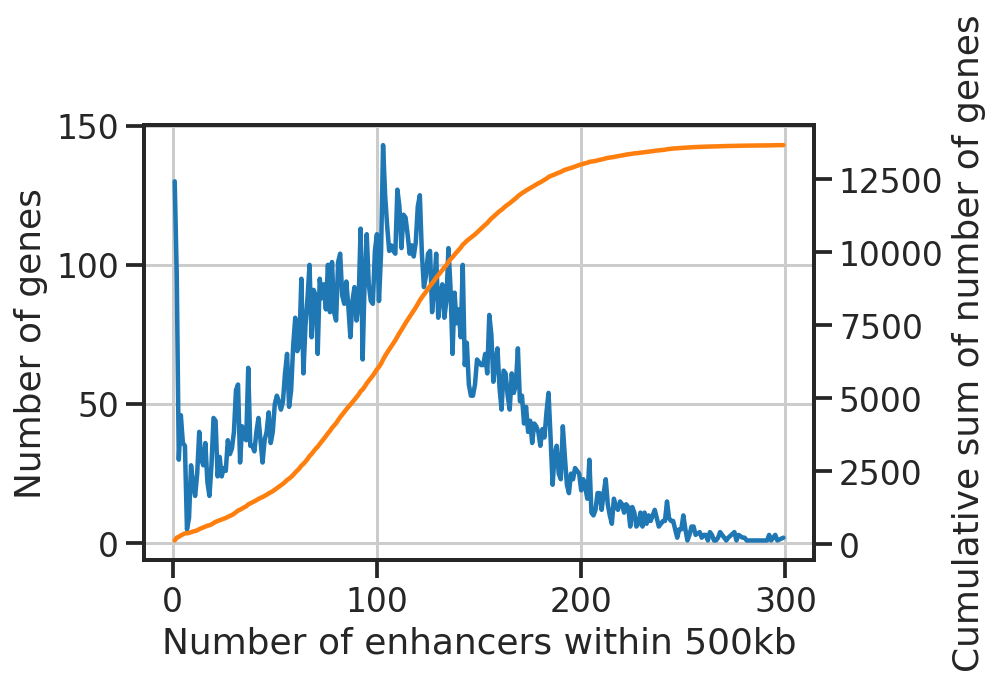

In [59]:
a = to_evals.groupby('gene').size().sort_values() #.values
a = a.value_counts().sort_index() #.values

with sns.plotting_context('talk'):
    fig, ax = plt.subplots()
    ax.plot(a.index.values, a.values)
    ax.set_xlabel('Number of enhancers within 500kb')
    ax.set_ylabel('Number of genes')
    ax2 = ax.twinx()
    ax2.plot(a.index.values, np.cumsum(a.values), color='C1', label='Cumulative')
    ax2.grid(False)
    ax2.set_ylabel('Cumulative sum of number of genes')
    
    output_name = '29-distribution-num-enhancers-per-gene' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')


### super enhancers 
start from ```to_evals```
- statistics on gene - cumulative effect of enhancers

In [60]:
th = -0.6
_tmp = to_evals.groupby('gene')
gene_score = _tmp.agg({'val': lambda x: np.sum(np.minimum(0, x-th))})
gene_score = gene_score.join(_tmp.agg({'val': lambda x: np.sum(x<th)}).fillna(0).astype(int),
                            lsuffix='_score', rsuffix='_num')

gene_score.sort_values('val_score').head()

,val_score,val_num
gene,,
Tcf4,-18.581067,104
Foxp1,-16.526056,119
Epha4,-11.953623,80
Camk2a,-11.670675,83
Nfib,-10.682084,64


In [61]:
th = -0.6
_tmp = to_evals_shuffled.groupby('gene')
gene_score_shuffled = _tmp.agg({'val': lambda x: np.sum(np.minimum(0, x-th))})
gene_score_shuffled = gene_score_shuffled.join(_tmp.agg({'val': lambda x: np.sum(x<th)}).fillna(0).astype(int),
                            lsuffix='_score', rsuffix='_num')

gene_score_shuffled.sort_values('val_score').head()

,val_score,val_num
gene,,
Camk2a,-9.279556,72
R3hdm1,-6.565649,52
Hkdc1,-6.531360,73
Psrc1,-6.233364,56
Fbxw7,-6.059574,58


In [62]:
# plt.plot(_X[snmcseq_utils.get_index_from_array(_x_features, gene_score.sort_values('val').index.values)].sum(axis=1)[:30])
# sns.distplot(_X[snmcseq_utils.get_index_from_array(_x_features, gene_score.sort_values('val').index.values)].sum(axis=1))
# plt.plot(_X[snmcseq_utils.get_index_from_array(_x_features, gene_score_shuffled.sort_values('val').index.values)].sum(axis=1)[:100])

In [63]:
corr_tracks = np.array([
    gene_score_shuffled['val_score'].values,
    gene_score['val_score'].values,
])

labels = np.array([
    'Gene score shuffled',
    'Gene score',
])

colors = np.array([
    'C0',
    'C1',
])

subsample_rates = np.array([
    1,
    1,
])

In [64]:
# FDR
bins_eval = np.linspace(-12, 0, 1000)

# background
x_bck = np.sort(corr_tracks[0])
y_bck = np.arange(len(x_bck))/len(x_bck)

# fore-ground - 1
x_fr = np.sort(corr_tracks[1])
y_fr = np.arange(len(x_fr))/len(x_fr)

# ratio 0
fdr_multi = fdr(bins_eval, x_bck, y_bck, x_fr, y_fr)

# plt.plot(bins_eval, fdr_multi)

    

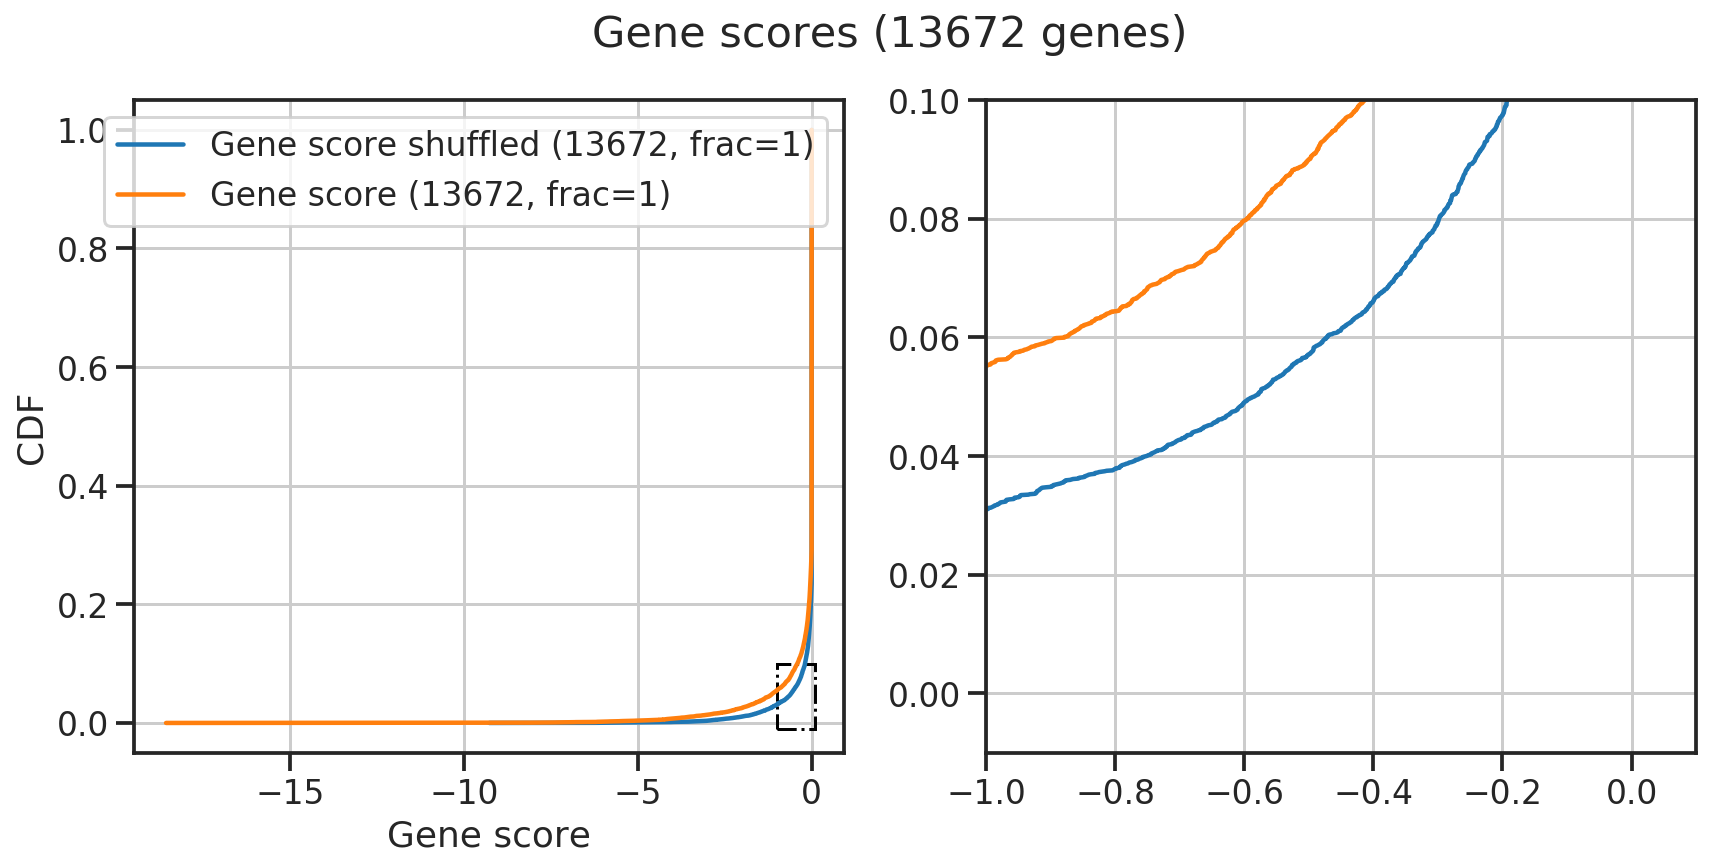

In [65]:
# plot
with sns.plotting_context('talk'):
    fig, axs = plt.subplots(1, 2, figsize=(7*2,6))
    ax = axs[0]
    for _x, label, color, subsample_rate in zip(corr_tracks, labels, colors, subsample_rates):
        linestyle = '-'
        ax.plot(np.sort(_x), np.arange(len(_x))/len(_x), 
                linestyle,
                label='{} ({}, frac={})'.format(label, len(_x), subsample_rate),
                color=color,
               )

    ax.legend()
    ax.set_xlabel('Gene score')
    ax.set_ylabel('CDF')
    
    xmin, xmax, ymin, ymax = -1, 0.1, -0.01, 0.1
    ax.add_patch(Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=None, color='black', linestyle='-.'))
    
    ax = axs[1]
    for _x, label, color, subsample_rate in zip(corr_tracks, labels, colors, subsample_rates):
        linestyle = '-'
        ax.plot(np.sort(_x), np.arange(len(_x))/len(_x), 
                linestyle,
                label='{} ({}, frac={})'.format(label, len(_x), subsample_rate),
                color=color,
               )

    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
    
    fig.suptitle('Gene scores ({} genes)'.format(len(gene_score)), 
                )
    
#     fig.tight_layout()
    output_name = '30-super-enhancers-score' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    plt.show()

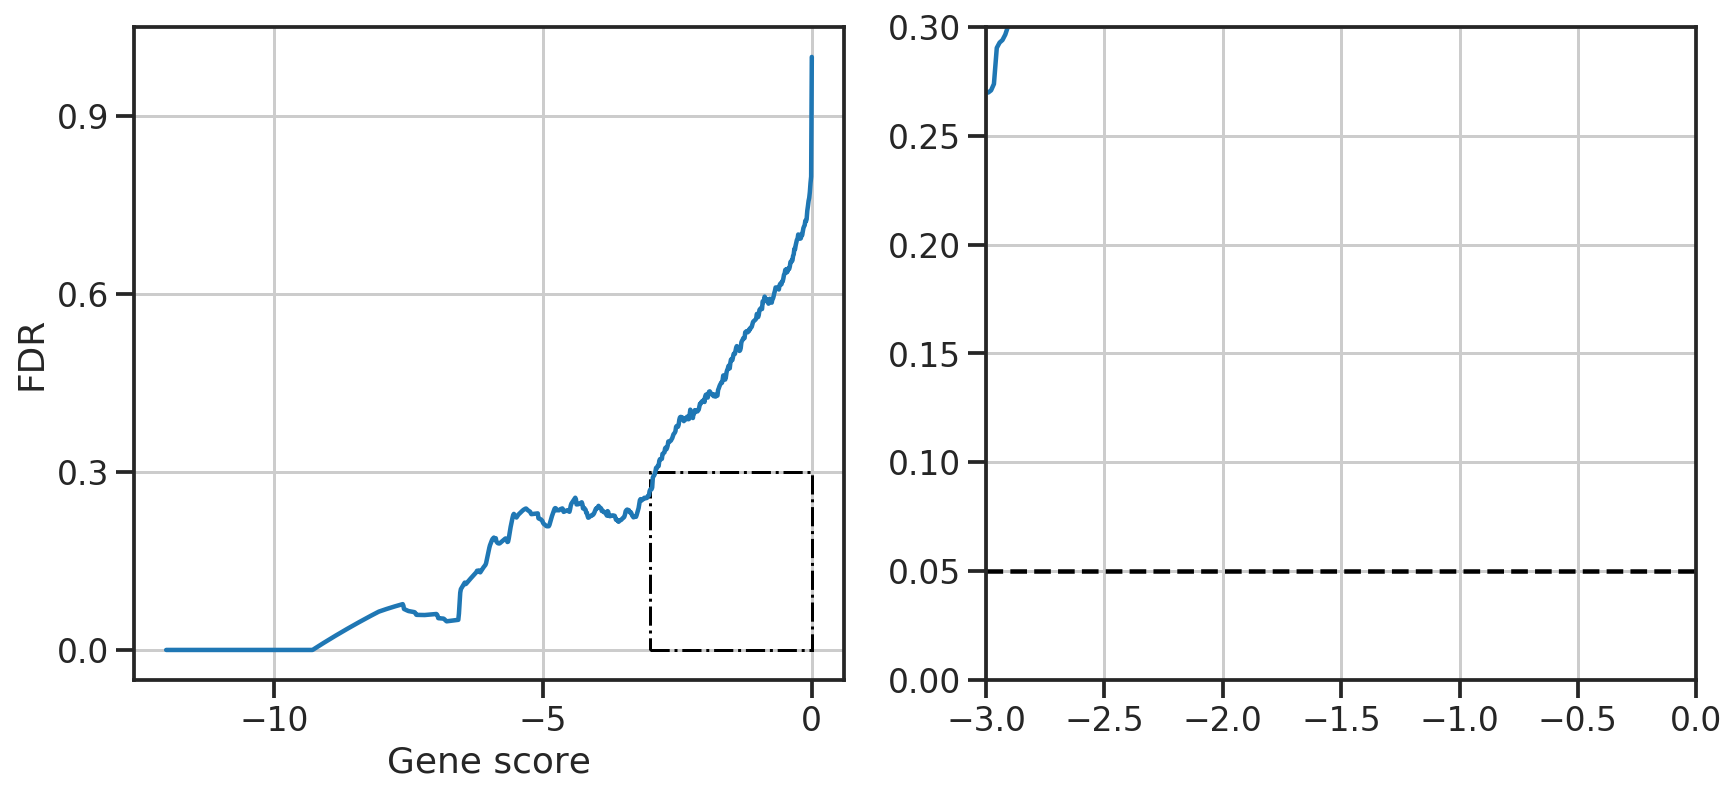

In [66]:
from matplotlib.patches import Rectangle
with sns.plotting_context('talk'):
    # inner box
#     xmin_1, xmax_1, ymin_1, ymax_1 = -0.8, 0.8, 0, 1 
    xmin, xmax, ymin, ymax = -3, 0, 0, 0.3 
    
    fig, axs = plt.subplots(1, 2, figsize=(7*2, 6*1))
    ax = axs[0]
    ax.plot(bins_eval, fdr_multi, 
#             label=labels[2], color=colors[2],
           )
#     ax.set_xlim([xmin_1, xmax_1])
#     ax.set_ylim([ymin_1, ymax_1])
#     ax.legend()
    ax.set_xlabel('Gene score')
    ax.set_ylabel('FDR')
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.add_patch(Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=None, color='black', linestyle='-.'))

    ax = axs[1]
    ax.plot(bins_eval, fdr_multi, 
#             label=labels[2], color=colors[2],
           )
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
    ax.axhline(0.05, color='black', linestyle='--')
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))

    output_name = '31-super-enhancers-fdrs' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    plt.show()

In [67]:
th = 0.1
gene_score['fdr'] = gene_score['val_score'].apply(lambda x: fdr(x, x_bck, y_bck, x_fr, y_fr))
res_multi = gene_score[gene_score['fdr']<th].sort_values('val_score')
print(res_multi.shape)
res_multi.head()

(20, 3)


,val_score,val_num,fdr
gene,,,
Tcf4,-18.581067,104,0.0
Foxp1,-16.526056,119,0.0
Epha4,-11.953623,80,0.0
Camk2a,-11.670675,83,0.0
Nfib,-10.682084,64,0.0


### Lots of heatmaps 

In [68]:
th2 = -0.6
to_plot = to_evals[to_evals['val']<th2] 

In [69]:
to_plot.shape

(35043, 8)

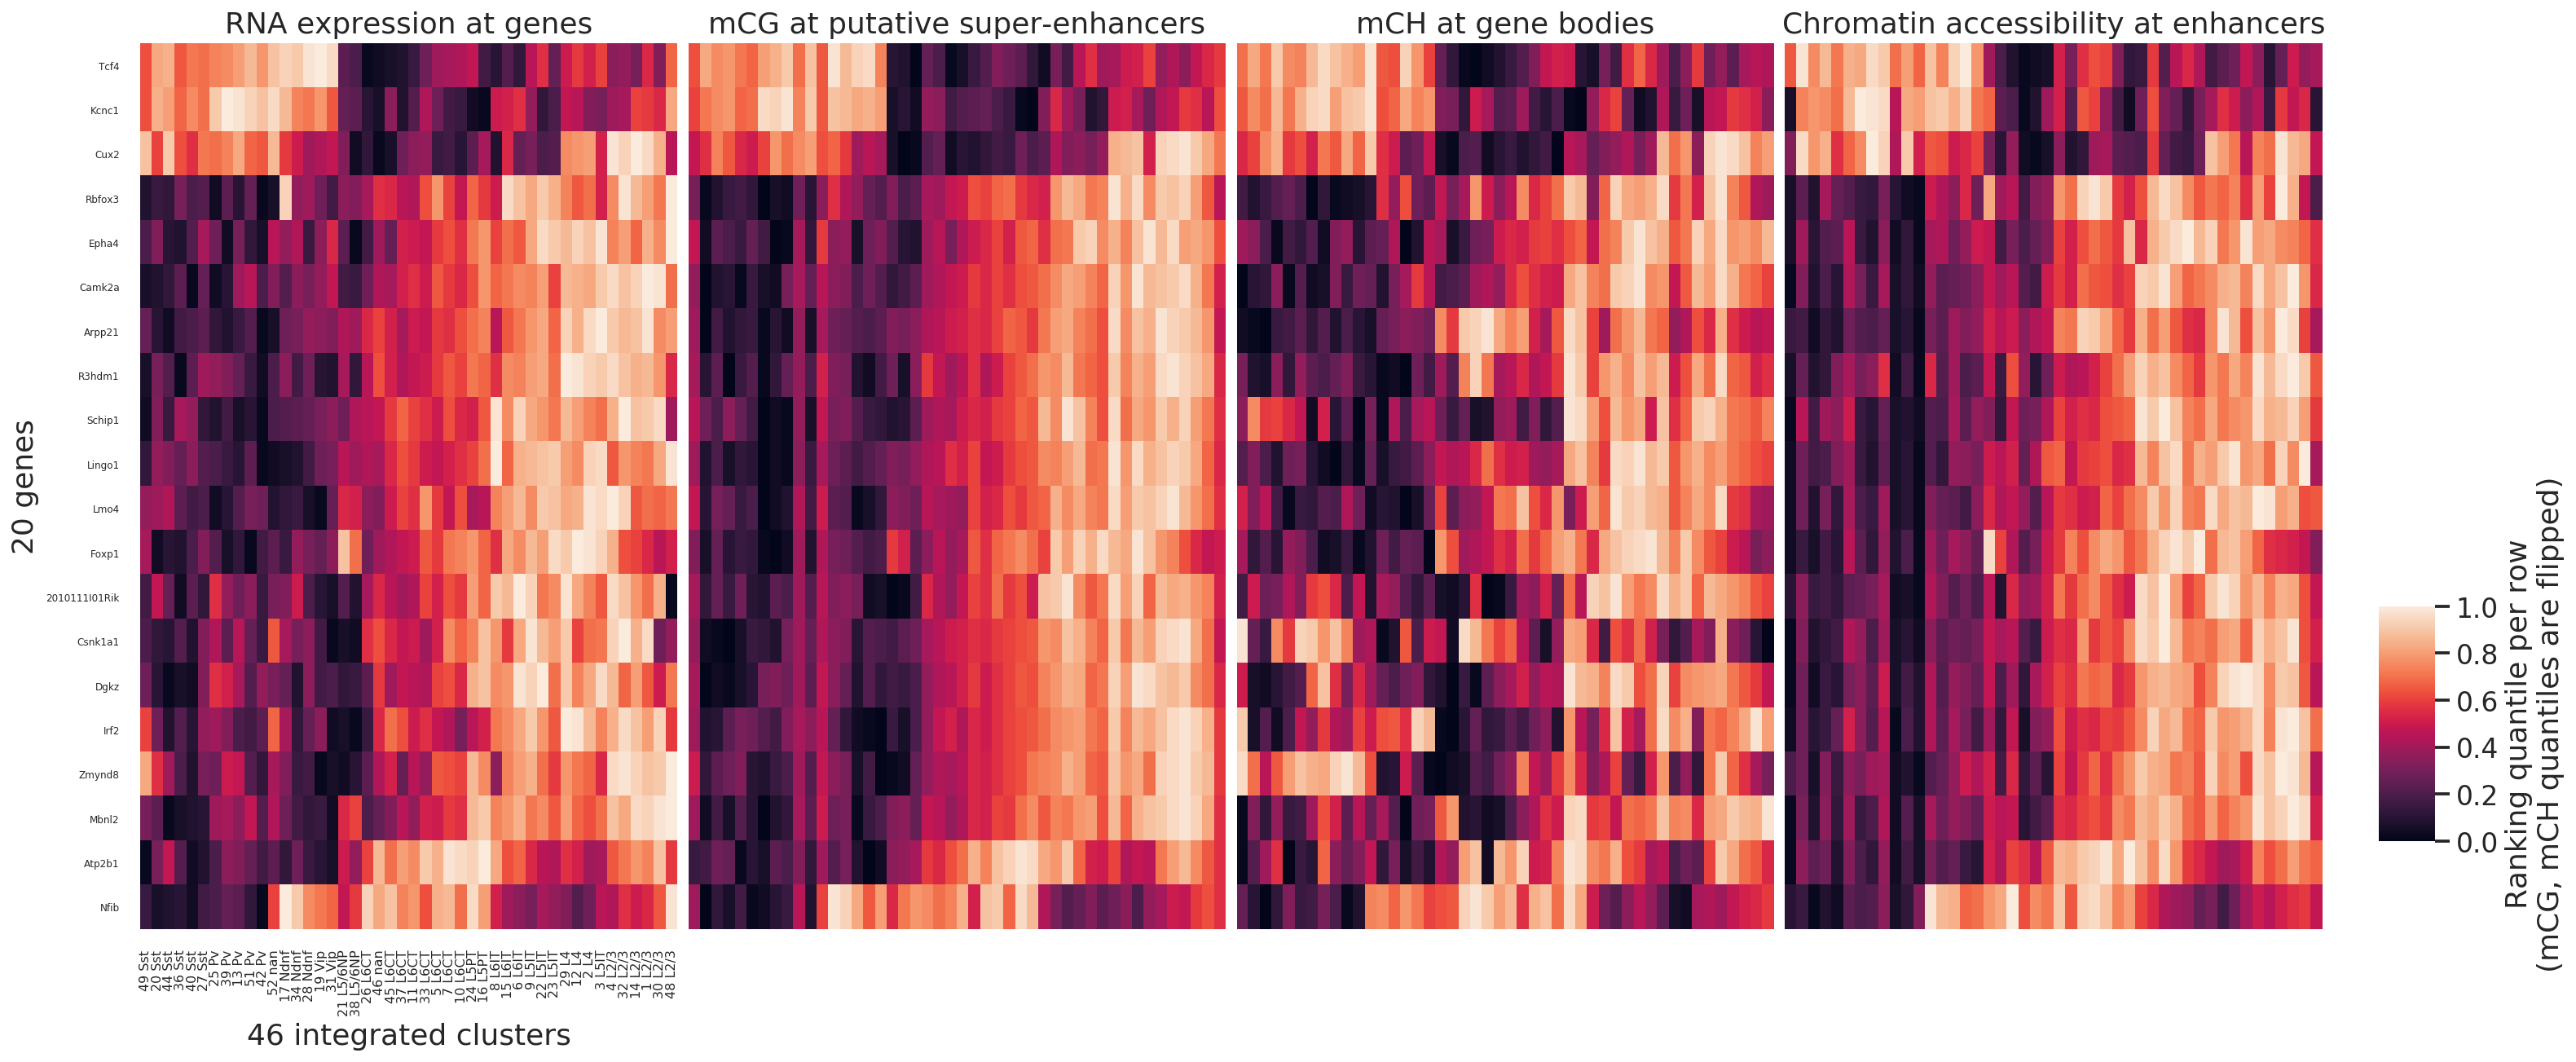

In [70]:
# heatmap of gene by cluster
# set_matplotlib_formats('pdf')

cmap = 'rocket'

# rna at genes 
rna_mat = gene_rna_clsts.loc[res_multi.index.values, clusters_selected]
rna_mat_norm = rna_mat.rank(pct=True, axis=1) #.apply(zscore, axis=1)

# row gene
Z = sch.linkage(rna_mat_norm, method='average', metric='euclidean', optimal_ordering=True)
dn = sch.dendrogram(Z, no_plot=True)

# col clst
Z = sch.linkage(rna_mat_norm.T, method='average', metric='euclidean', optimal_ordering=True)
dn_clst = sch.dendrogram(Z, no_plot=True)

genes_ordered = rna_mat_norm.index.values[dn['leaves']]
ens_ordered = to_plot.set_index('gene').loc[genes_ordered]

# mCH at genes
mch_mat = gene_mch_clsts.reindex(genes_ordered).loc[:, clusters_selected]

# mC at enhancers 
mcc_mat = enh_mcg_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
mcc_mat['gene'] = ens_ordered.index.values
mcc_mat = mcc_mat.groupby('gene').mean().loc[genes_ordered]

# # ATAC at enhancers
atac_mat = enh_atac_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
atac_mat['gene'] = ens_ordered.index.values
atac_mat = atac_mat.groupby('gene').mean().loc[genes_ordered]

with sns.plotting_context('talk'), sns.axes_style('white'):
    fig, axs = plt.subplots(1, 4, figsize=(6*4,10))
    cbar_ax = fig.add_axes([.92, .2, .02, .2])
    
    ax = axs[0]
    g = sns.heatmap(rna_mat_norm.iloc[dn['leaves'], dn_clst['leaves']],
                    xticklabels=clusters_selected_labels[dn_clst['leaves']], 
#                     xticklabels=False,
                    yticklabels=True,
                    vmin=0, vmax=1,
                    ax=ax,
                    cmap=cmap,
                    cbar_ax=cbar_ax,
                    cbar_kws={'fraction': 0.05, 
                              'label': 'Ranking quantile per row\n(mCG, mCH quantiles are flipped)',
                             }, 
                   )
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)
    ax.set_title('RNA expression at genes')
    ax.set_xlabel('{} integrated clusters'.format(len(dn_clst['leaves'])))
    ax.set_ylabel('{} genes'.format(len(dn['leaves'])))

    ax = axs[1]
    g = sns.heatmap((1-mcc_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']], 
                    yticklabels=False,
                    xticklabels=False, 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    ax=ax)
    ax.set_title('mCG at putative super-enhancers')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = axs[2]
    g = sns.heatmap((1-mch_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']],
                    yticklabels=False,
                    xticklabels=False, 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    ax=ax)
    ax.set_title('mCH at gene bodies')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = axs[3]
    g = sns.heatmap(atac_mat.rank(axis=1, pct=True).iloc[:, dn_clst['leaves']], 
                    yticklabels=False,
                    xticklabels=False, 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    ax=ax)
    ax.set_title('Chromatin accessibility at enhancers')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_xlabel('')
    ax.set_ylabel('')

    fig.subplots_adjust(wspace=0.02, hspace=0.08)
    
    output_name = '32-heatmap-examples-super-enhancers' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    plt.show()

In [71]:
# # heatmap of gene by cluster
# # set_matplotlib_formats('pdf')

# cmap = 'rocket'

# # rna at genes 
# rna_mat = gene_rna_clsts.loc[res_multi.index.values, clusters_selected]
# rna_mat_norm = rna_mat.rank(pct=True, axis=1) #.apply(zscore, axis=1)

# # row gene
# Z = sch.linkage(rna_mat_norm, method='average', metric='euclidean', optimal_ordering=True)
# dn = sch.dendrogram(Z, no_plot=True)

# # col clst
# Z = sch.linkage(rna_mat_norm.T, method='average', metric='euclidean', optimal_ordering=True)
# dn_clst = sch.dendrogram(Z, no_plot=True)

# # ordered
# genes_ordered = rna_mat_norm.index.values[dn['leaves']]
# ens_ordered = to_plot.set_index('gene').loc[genes_ordered]

# # RNA at genes again
# rna_mat_norm = rna_mat_norm.loc[ens_ordered.index.values]
# # mCH at genes
# mch_mat = gene_mch_clsts.reindex(ens_ordered.index.values).loc[:, clusters_selected]

# # mC at enhancers 
# mcc_mat = enh_mcg_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
# # mcc_mat['gene'] = ens_ordered.index.values
# # mcc_mat = mcc_mat.groupby('gene').mean().loc[genes_ordered]

# # # ATAC at enhancers
# atac_mat = enh_atac_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
# # atac_mat['gene'] = ens_ordered.index.values
# # atac_mat = atac_mat.groupby('gene').mean().loc[genes_ordered]

# with sns.plotting_context('talk'), sns.axes_style('white'):
#     fig, axs = plt.subplots(1, 4, figsize=(6*4,10))
#     cbar_ax = fig.add_axes([.92, .2, .02, .2])
    
#     ax = axs[0]
#     g = sns.heatmap(rna_mat_norm.iloc[:, dn_clst['leaves']],
#                     xticklabels=clusters_selected_labels[dn_clst['leaves']], 
# #                     xticklabels=False,
#                     yticklabels=remove_dup_labels_from_array(rna_mat_norm.index.values),
#                     vmin=0, vmax=1,
#                     ax=ax,
#                     cmap=cmap,
#                     cbar_ax=cbar_ax,
#                     cbar_kws={'fraction': 0.05, 
#                               'label': 'Ranking quantile per row\n(mCG, mCH quantiles are flipped)',
#                              }, 
#                    )
#     ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
#     ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)
#     ax.set_title('RNA expression at genes')
#     ax.set_xlabel('{} integrated clusters'.format(len(dn_clst['leaves'])))
#     ax.set_ylabel('{} genes'.format(len(dn['leaves'])))

#     ax = axs[1]
#     g = sns.heatmap((1-mcc_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']], 
#                     yticklabels=False,
#                     xticklabels=False, 
#                     vmin=0, vmax=1,
#                     cbar=False,
#                     cmap=cmap,
#                     ax=ax)
#     ax.set_title('mCG at putative super-enhancers')
#     ax.set_xlabel('')
#     ax.set_ylabel('')
    
#     ax = axs[2]
#     g = sns.heatmap((1-mch_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']],
#                     yticklabels=False,
#                     xticklabels=False, 
#                     vmin=0, vmax=1,
#                     cbar=False,
#                     cmap=cmap,
#                     ax=ax)
#     ax.set_title('mCH at gene bodies')
#     ax.set_xlabel('')
#     ax.set_ylabel('')
    
#     ax = axs[3]
#     g = sns.heatmap(atac_mat.rank(axis=1, pct=True).iloc[:, dn_clst['leaves']], 
#                     yticklabels=False,
#                     xticklabels=False, 
#                     vmin=0, vmax=1,
#                     cbar=False,
#                     cmap=cmap,
#                     ax=ax)
#     ax.set_title('Chromatin accessibility at enhancers')
#     ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
#     ax.set_xlabel('')
#     ax.set_ylabel('')

#     fig.subplots_adjust(wspace=0.02, hspace=0.08)
#     plt.show()

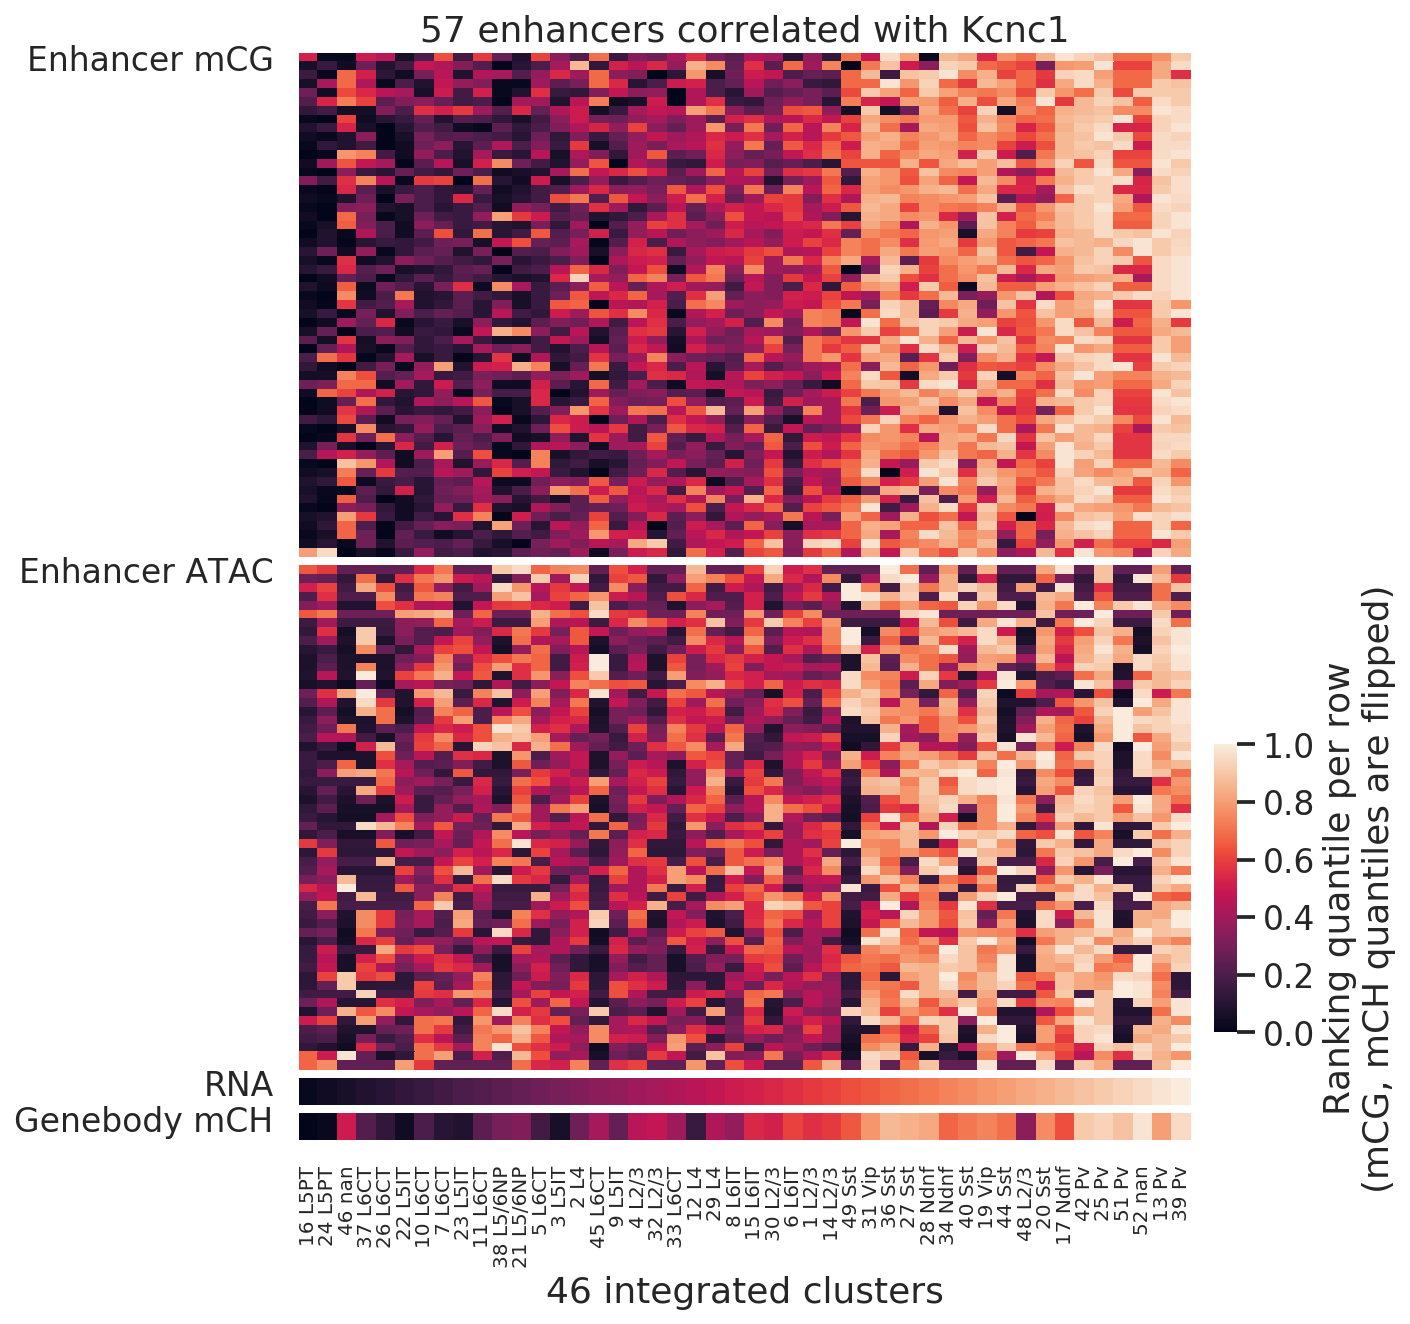

In [72]:
# heatmap of gene by cluster
set_matplotlib_formats('retina')

cmap = 'rocket'
gene = 'Kcnc1'

# rna at genes 
rna_mat = gene_rna_clsts.loc[[gene], clusters_selected]
rna_mat_norm = rna_mat.rank(pct=True, axis=1) #.apply(zscore, axis=1)


# ordered
ens_ordered = to_plot.set_index('gene').loc[gene]
clst_idx_ordered = np.argsort(rna_mat_norm.values.flatten())

# mCH at genes
mch_mat = gene_mch_clsts.loc[[gene], clusters_selected]

# mC at enhancers 
mcc_mat = enh_mcg_clsts.loc[ens_ordered['ens'].values, clusters_selected] 

# # ATAC at enhancers
atac_mat = enh_atac_clsts.loc[ens_ordered['ens'].values, clusters_selected] 

# organize heatmap to plot
n_repeats = 3
blank_repeats = 1

heatmap_all = np.vstack([
    # mcg
    (1-mcc_mat.rank(axis=1, pct=True)).iloc[:, clst_idx_ordered],    
    np.repeat(np.full(len(clst_idx_ordered), np.nan).reshape(1, -1), blank_repeats, axis=0),
    
    # atac
     atac_mat.rank(axis=1, pct=True).iloc[:, clst_idx_ordered],
    np.repeat(np.full(len(clst_idx_ordered), np.nan).reshape(1, -1), blank_repeats, axis=0),
    
    # rna
    np.repeat(rna_mat_norm.iloc[:, clst_idx_ordered].values, n_repeats, axis=0),
    np.repeat(np.full(len(clst_idx_ordered), np.nan).reshape(1, -1), blank_repeats, axis=0),
    
    # mch
    np.repeat((1-mch_mat.rank(axis=1, pct=True)).iloc[:, clst_idx_ordered].values, n_repeats, axis=0),
])

yticklabels = np.hstack([
    ['Enhancer mCG']*(len(mcc_mat) + blank_repeats),
    ['Enhancer ATAC']*(len(atac_mat) + blank_repeats),
    ['RNA']*(n_repeats + blank_repeats),
    ['Genebody mCH']*n_repeats,
])
yticklabels = snmcseq_utils.dedup_array_elements(yticklabels)

with sns.plotting_context('talk'), sns.axes_style('white'):
    fig, ax = plt.subplots(1, 1, figsize=(8,10))
    cbar_ax = fig.add_axes([.92, .2, .02, .2])
    
    g = sns.heatmap(heatmap_all, 
                    xticklabels=clusters_selected_labels[clst_idx_ordered],
                    yticklabels=yticklabels, 
                    vmin=0, vmax=1,
                    cbar_ax=cbar_ax,
                    cbar_kws={'fraction': 0.05, 
                              'label': 'Ranking quantile per row\n(mCG, mCH quantiles are flipped)',
                             }, 
                    cmap=cmap,
                    ax=ax)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_xlabel('{} integrated clusters'.format(mcc_mat.shape[1]))
    ax.set_title('{} enhancers correlated with {}'.format(len(mcc_mat), gene))
    
    output_name = '33-heatmap-1example-super-enhancers' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
#     fig.subplots_adjust(wspace=0.02, hspace=0.08)
    plt.show()

In [190]:
# # oncology
# strg = '\n'.join(res_multi.index.values.tolist())
# print(strg)

bed = regions.set_index('index').loc[ens_ordered['ens'].values].reset_index()[['chrom', 'start', 'end', 'index']]
bed.to_csv('/cndd/fangming/CEMBA/data/MOp_all/enhancers_may1/enhancers_june19/kcnc1_enhancers.tsv', 
           sep='\t', na_rep='NA',
           header=False, index=False, 
          )

In [192]:
bed['len'] = bed['end'] - bed['start']
bed.sort_values('len').tail()

,chrom,start,end,index,len
51,7,46601280,46602520,112369,1240
44,7,46550595,46552049,112354,1454
13,7,46411785,46413317,112301,1532
20,7,46423143,46425164,112310,2021
9,7,46405116,46407280,112296,2164


### one example correlation

In [82]:
to_evals.sort_values('val').head()

,gene,ens,val,dist,fdr-500k,fdr-200k,fdr-100k,pvalues
1172911,Slc1a2,73274,-0.935862,17801,0.318727,0.148477,0.077258,0.000001
695953,Khdrbs3,46464,-0.934012,59247,0.318727,0.148477,0.077258,0.000001
1151208,Sez6,21042,-0.932655,11377,0.318727,0.148477,0.077258,0.000001
683852,Kcnc1,112296,-0.932408,9701,0.318727,0.148477,0.077258,0.000001
276044,Chst1,72808,-0.930928,4907,0.318727,0.148477,0.077258,0.000001


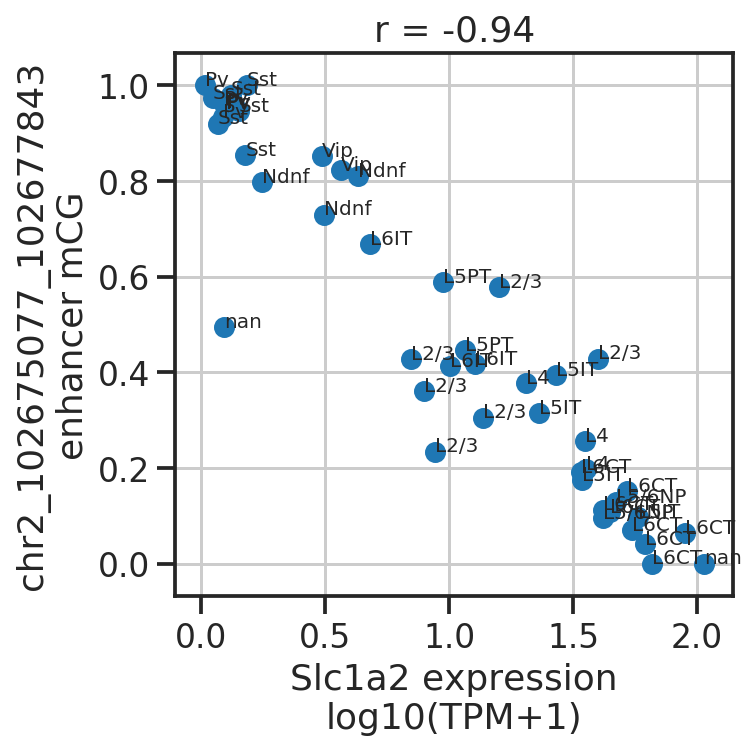

In [123]:
gene = 'Slc1a2'
enh = 73274
enh_name = 'chr'+'_'.join(regions.set_index('index').loc[enh].astype(str).tolist())


_x = gene_rna_clsts.loc[gene, clusters_selected]
_y = enh_mcg_clsts.loc[enh, clusters_selected]
_c = pd.Series(clst_annot)[clusters_selected]

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(_x.values, _y.values)
r, p = stats.spearmanr(_x.values, _y.values)
ax.set_title('r = {:.2f}'.format(r))
for __x, __y, __c in zip(_x, _y, _c):
    ax.text(__x, __y, __c)
ax.set_ylabel('{}\nenhancer mCG'.format(enh_name))
ax.set_xlabel('{} expression\nlog10(TPM+1)'.format(gene))

output_name = '34_example_corr' 
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()

### FDR